## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'spaceNet-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'green'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
green_wavelet_full_spaceNet.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/michaelmurphy/Documents/GitHub/hierarchical-bayesian-model-validation/results/case-studies/spaceNet/full/wavelet/green'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 27208,
 3: 108832,
 4: 333298,
 5: 1149538,
 6: 4251250,
 7: 17005000,
 8: 68020000,
 9: 272080000}

Running 12760 CDFs


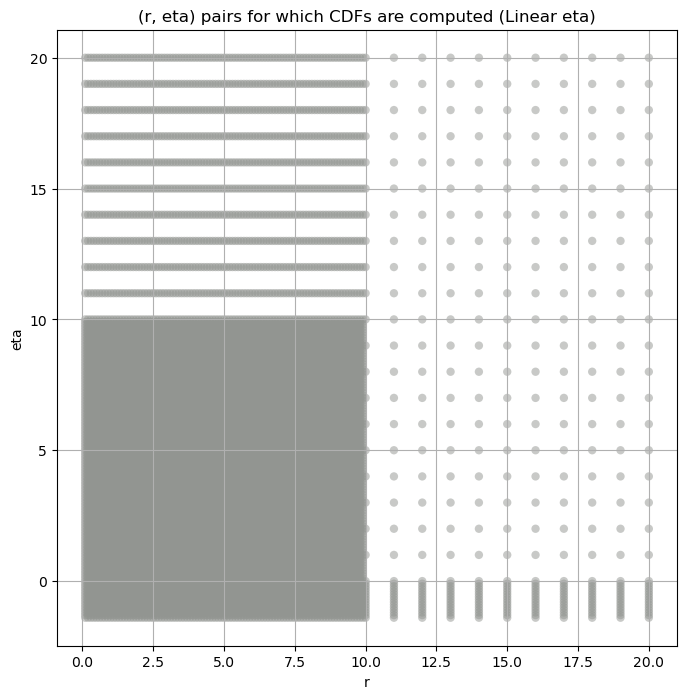

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:24<00:00, 4139.40it/s]


Layer 3


100%|██████████| 100000/100000 [00:24<00:00, 4034.67it/s]


Layer 4


100%|██████████| 100000/100000 [00:24<00:00, 4053.68it/s]


Layer 5


100%|██████████| 100000/100000 [00:24<00:00, 4110.60it/s]


Layer 6


100%|██████████| 100000/100000 [00:24<00:00, 4083.55it/s]


Layer 7


100%|██████████| 100000/100000 [00:24<00:00, 4065.87it/s]


Layer 8


100%|██████████| 100000/100000 [00:24<00:00, 4070.18it/s]


Layer 9


100%|██████████| 100000/100000 [00:24<00:00, 4120.35it/s]


obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                     
2      20586.120000  19258.777000  21997.203000    4.579008    3.067372   
3       5586.042500   5083.030300   6169.862300   12.162527    6.823176   
4       1803.625200   1653.475500   1972.172700    9.509400    6.386293   
5        518.531700    474.718600    568.606450   10.222363    6.526305   
6        123.448410    112.812614    135.501390   10.630472    6.988778   
7         26.474886     23.729076     30.007523   18.564669    9.779378   
8          5.566022      4.824710      6.910763   45.434100   13.918406   
9          1.021803      0.856540      1.428081  105.147964   15.814442   

       kurt_upper  total_samples  
layer                             
2        6.877853        27208.0  
3       25.538519       108832.0  
4       18.198275       333298.0  
5       26.454138      1149538.0  
6       22.231544      4251250.0  
7       60.509160     17005000.0  
8      216.776810     68020000.0  
9      464.557600    272080000.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      20586.120000   20586.119141    19327.277344    18633.058594   
3       5586.042500    5586.042480     5321.487793     5194.312012   
4       1803.625200    1803.625244     1735.333252     1696.416382   
5        518.531700     518.531677      499.052856      487.948181   
6        123.448410     123.448410      118.563240      115.735970   
7         26.474886      26.474886       25.031025       24.278360   
8          5.566022       5.566022        5.113525        4.912745   
9          1.021803       1.021803        0.905178        0.864544   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        18071.634766     17581.818359     16734.537109     16019.993164   
3         5091.314941      5001.927246      4847.825195      4717.371094   
4         1664.521118      1636.698242      1588.496704      1546.769653   
5          478.679169       470.541168       456.467468       444.316223   
6          113.420433       111.400955       107.936569       104.980225   
7           23.675591        23.159367        22.285318        21.546915   
8            4.756459         4.625241         4.408093         4.228874   
9            0.833975         0.808776         0.767817         0.734637   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         15399.413086     14845.077148     14336.416016     13035.737305  
3          4601.997559      4497.110840      4401.297852      4152.544434  
4          1509.813599      1476.338867      1445.372681      1364.695435  
5           433.501099       423.715668       414.720093       391.182007  
6           102.353752        99.973602        97.788719        92.085335  
7            20.899561        20.318769        19.789452        18.425821  
8             4.074505         3.938030         3.815335         3.505627  
9             0.706432         0.681747         0.659726         0.604809

####
Layer  2


100%|██████████| 12760/12760 [00:13<00:00, 961.02it/s] 


Finding Minimum after computing 12760 CDFs
2 0 0.014079478815237523 20586.12


100%|██████████| 12760/12760 [00:12<00:00, 1019.10it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.014191910468952296 19327.277


100%|██████████| 12760/12760 [00:13<00:00, 953.86it/s] 


Finding Minimum after computing 12760 CDFs
2 50 0.01427853493255804 18633.059


100%|██████████| 12760/12760 [00:12<00:00, 1061.71it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.014352060141874068 18071.635


100%|██████████| 12760/12760 [00:11<00:00, 1065.56it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.014418960194366837 17581.818


100%|██████████| 12760/12760 [00:12<00:00, 1038.12it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.016706247742331037 16734.537


100%|██████████| 12760/12760 [00:12<00:00, 1031.24it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.016830811287786462 16019.993


100%|██████████| 12760/12760 [00:12<00:00, 1054.44it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.017153219514624507 15399.413


100%|██████████| 12760/12760 [00:12<00:00, 1053.92it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.017372779867596944 14845.077


100%|██████████| 12760/12760 [00:12<00:00, 1055.72it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.01927092695677257 14336.416


100%|██████████| 12760/12760 [00:11<00:00, 1066.78it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.025230280863620225 13035.737
Number of samples: 27208, Without approximation : 27208.0


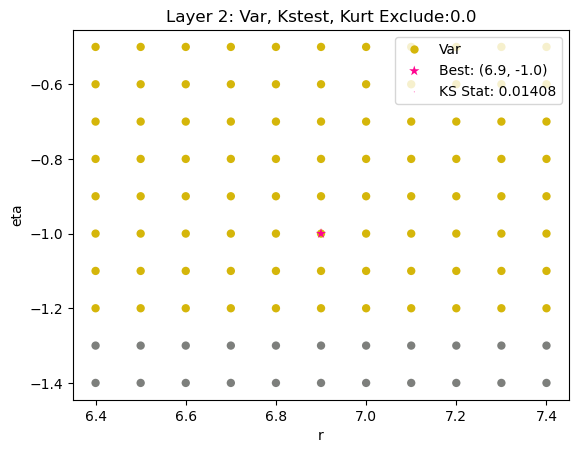

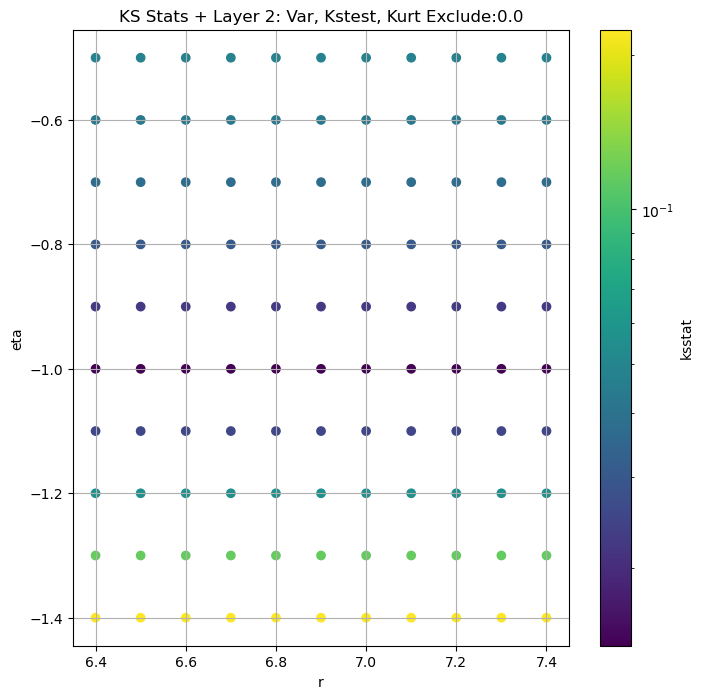

####
Layer  3


100%|██████████| 12760/12760 [00:43<00:00, 294.45it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.1330799999999998 5586.0425


100%|██████████| 12760/12760 [00:43<00:00, 295.12it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.1330799999999998 5321.488


100%|██████████| 12760/12760 [00:44<00:00, 289.64it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.1330799999999998 5194.312


100%|██████████| 12760/12760 [00:44<00:00, 288.39it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.1330799999999998 5091.315


100%|██████████| 12760/12760 [00:43<00:00, 292.03it/s]


Finding Minimum after computing 12760 CDFs
3 100 0.1330799999999998 5001.9272


100%|██████████| 12760/12760 [00:43<00:00, 293.77it/s]


Finding Minimum after computing 12760 CDFs
3 150 0.1330799999999998 4847.825


100%|██████████| 12760/12760 [00:43<00:00, 294.05it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.1330799999999998 4717.371


100%|██████████| 12760/12760 [00:43<00:00, 293.82it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.1330799999999998 4601.9976


100%|██████████| 12760/12760 [00:43<00:00, 294.13it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.1330799999999998 4497.111


100%|██████████| 12760/12760 [00:43<00:00, 292.11it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.1330799999999998 4401.298


100%|██████████| 12760/12760 [00:44<00:00, 289.88it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.1330799999999998 4152.5444
Number of samples: 100000, Without approximation : 108832.0


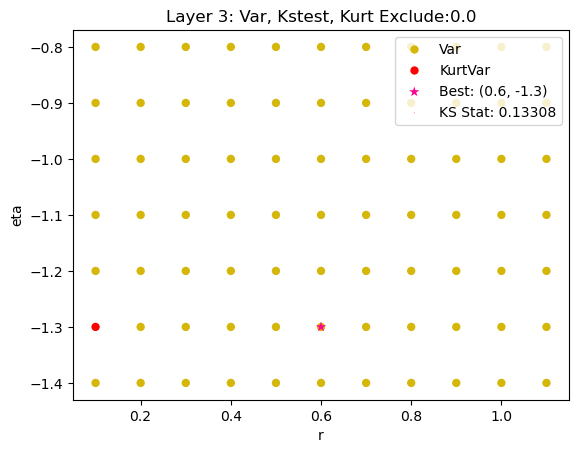

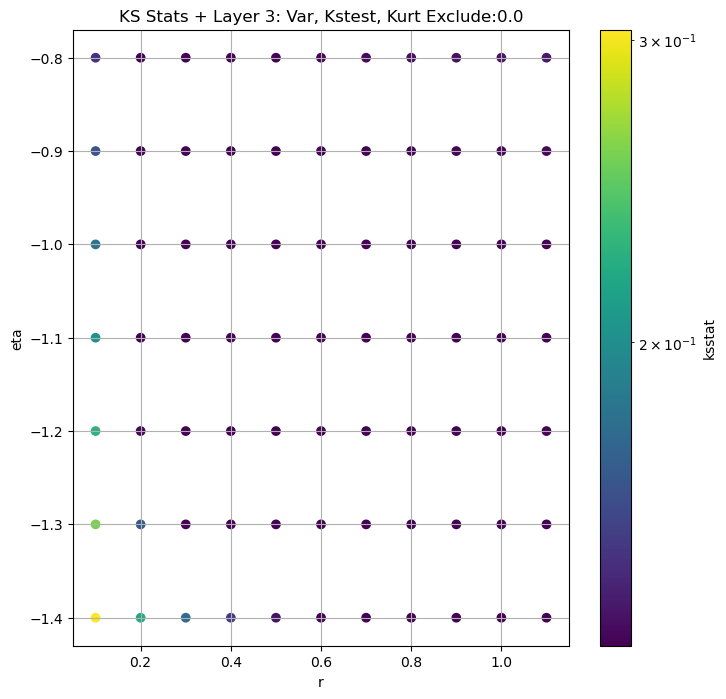

####
Layer  4


100%|██████████| 12760/12760 [00:43<00:00, 295.99it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.07779999999999981 1803.6252


100%|██████████| 12760/12760 [00:42<00:00, 297.52it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.07779999999999981 1735.3333


100%|██████████| 12760/12760 [00:43<00:00, 295.65it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.07779999999999981 1696.4164


100%|██████████| 12760/12760 [00:43<00:00, 293.75it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.07779999999999981 1664.5211


100%|██████████| 12760/12760 [00:43<00:00, 296.63it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.07779999999999981 1636.6982


100%|██████████| 12760/12760 [00:42<00:00, 299.04it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.07779999999999981 1588.4967


100%|██████████| 12760/12760 [00:43<00:00, 296.58it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.07779999999999981 1546.7697


100%|██████████| 12760/12760 [00:43<00:00, 295.09it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.07779999999999981 1509.8136


100%|██████████| 12760/12760 [00:43<00:00, 294.38it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.07779999999999981 1476.3389


100%|██████████| 12760/12760 [00:43<00:00, 295.38it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.07779999999999981 1445.3727


100%|██████████| 12760/12760 [00:43<00:00, 296.04it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.07779999999999981 1364.6954
Number of samples: 100000, Without approximation : 333298.0


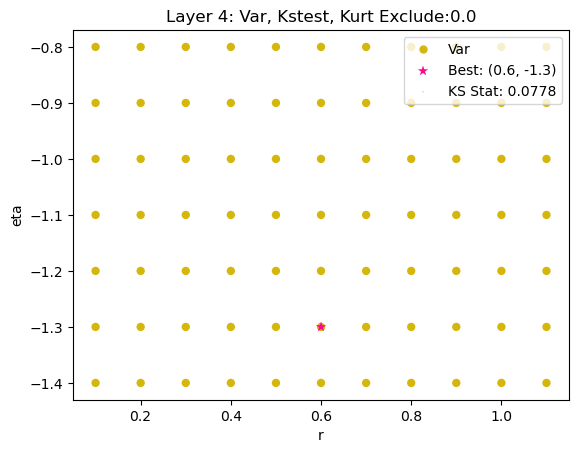

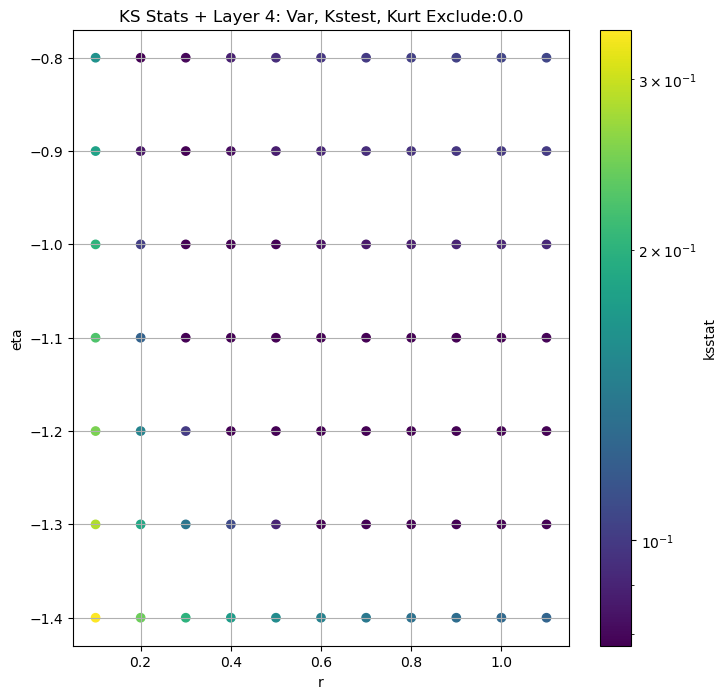

####
Layer  5


100%|██████████| 12760/12760 [00:43<00:00, 295.97it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.043061326136958955 518.5317


100%|██████████| 12760/12760 [00:43<00:00, 295.51it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.04306057861902357 499.05286


100%|██████████| 12760/12760 [00:43<00:00, 296.04it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.04306114168036007 487.94818


100%|██████████| 12760/12760 [00:43<00:00, 296.02it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.0430607672675557 478.67917


100%|██████████| 12760/12760 [00:43<00:00, 296.60it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.043060429461164784 470.54117


100%|██████████| 12760/12760 [00:43<00:00, 295.38it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.0430605577577699 456.46747


100%|██████████| 12760/12760 [00:43<00:00, 294.82it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.043060564426808 444.31622


100%|██████████| 12760/12760 [00:43<00:00, 294.23it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.043060295718224395 433.5011


100%|██████████| 12760/12760 [00:43<00:00, 296.32it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.043060204388354006 423.71567


100%|██████████| 12760/12760 [00:43<00:00, 294.99it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.043060061142603856 414.7201


100%|██████████| 12760/12760 [00:43<00:00, 294.11it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.04305986856967786 391.182
Number of samples: 100000, Without approximation : 1149538.0


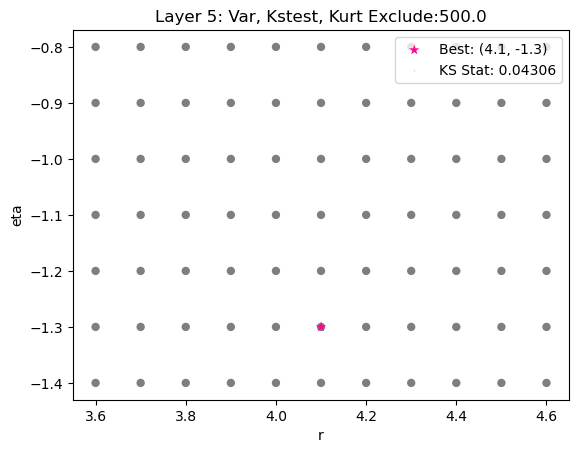

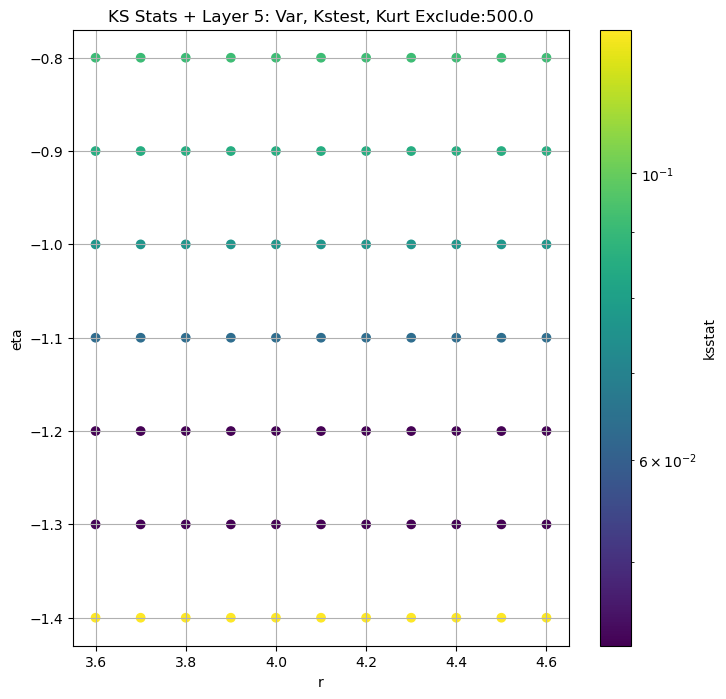

####
Layer  6


100%|██████████| 12760/12760 [00:43<00:00, 293.94it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.0135473639580872 123.44841


100%|██████████| 12760/12760 [00:44<00:00, 284.21it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.014038600762744102 118.56324


100%|██████████| 12760/12760 [00:46<00:00, 274.24it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.013580533715794596 115.73597


100%|██████████| 12760/12760 [00:46<00:00, 273.89it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.013504212871368992 113.42043


100%|██████████| 12760/12760 [00:46<00:00, 273.37it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.013883801308896215 111.400955


100%|██████████| 12760/12760 [00:46<00:00, 272.98it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.013839620312722067 107.93657


100%|██████████| 12760/12760 [00:46<00:00, 272.88it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.013594189482065921 104.980225


100%|██████████| 12760/12760 [00:46<00:00, 272.94it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.013821547023584735 102.35375


100%|██████████| 12760/12760 [00:47<00:00, 270.96it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.013971530799287368 99.9736


100%|██████████| 12760/12760 [00:46<00:00, 273.16it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.014059548007417488 97.78872


100%|██████████| 12760/12760 [00:46<00:00, 272.72it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.014057875698192168 92.085335
Number of samples: 100000, Without approximation : 4251250.0


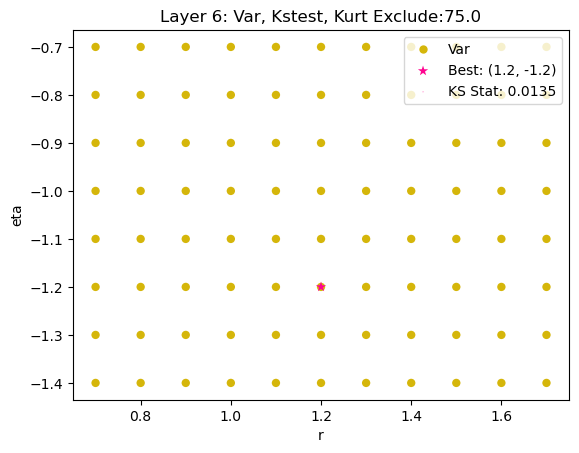

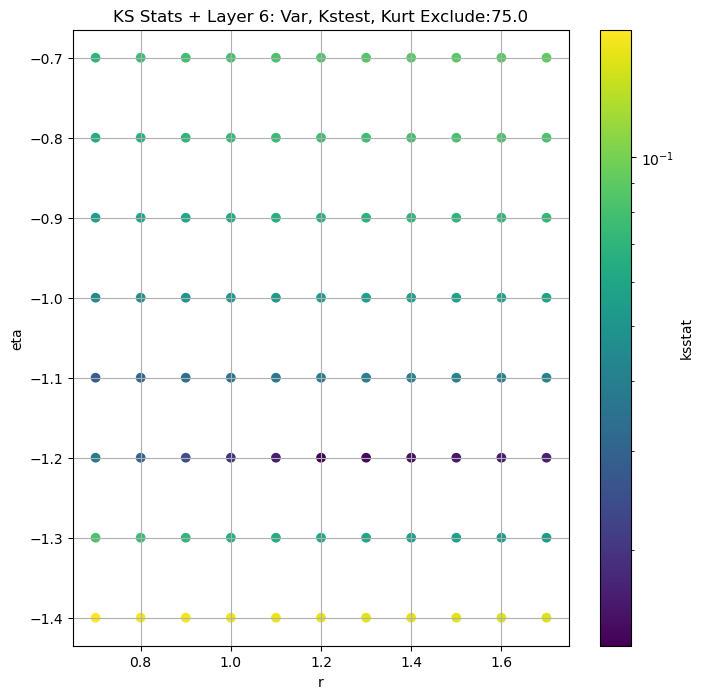

####
Layer  7


100%|██████████| 12760/12760 [00:46<00:00, 273.98it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.012748830447491533 26.474886


100%|██████████| 12760/12760 [00:46<00:00, 272.31it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.013246969276074938 25.031025


100%|██████████| 12760/12760 [00:46<00:00, 275.06it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.012835154503233803 24.27836


100%|██████████| 12760/12760 [00:46<00:00, 273.70it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.012769125727619846 23.67559


100%|██████████| 12760/12760 [00:46<00:00, 274.13it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.012964128826197019 23.159367


100%|██████████| 12760/12760 [00:46<00:00, 274.47it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.012680494573310552 22.285318


100%|██████████| 12760/12760 [00:46<00:00, 273.86it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.012815836272925873 21.546915


100%|██████████| 12760/12760 [00:47<00:00, 271.49it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.012684445076805329 20.89956


100%|██████████| 12760/12760 [00:46<00:00, 273.86it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.012759225722955403 20.31877


100%|██████████| 12760/12760 [00:46<00:00, 274.50it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.012624469573605968 19.789452


100%|██████████| 12760/12760 [00:46<00:00, 274.31it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.012728932557471373 18.425821
Number of samples: 100000, Without approximation : 17005000.0


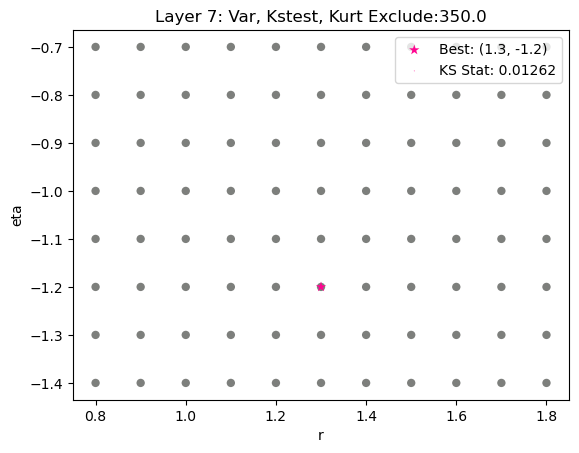

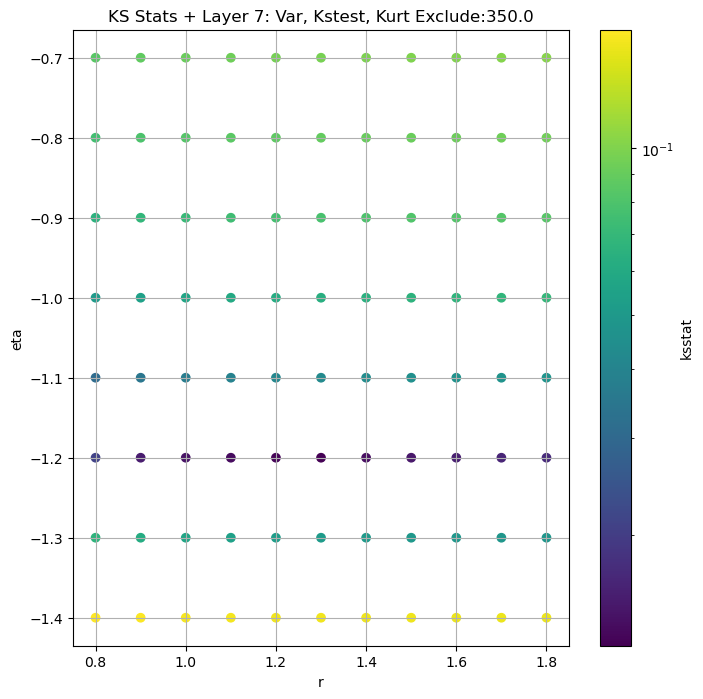

####
Layer  8


100%|██████████| 12760/12760 [00:46<00:00, 275.14it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.015180546818076457 5.566022


100%|██████████| 12760/12760 [00:46<00:00, 276.40it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.012393694777777853 5.1135254


100%|██████████| 12760/12760 [00:45<00:00, 282.05it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.012393567222772517 4.9127445


100%|██████████| 12760/12760 [00:45<00:00, 281.29it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.01239346239452499 4.756459


100%|██████████| 12760/12760 [00:45<00:00, 281.17it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.01378896344938281 4.6252413


100%|██████████| 12760/12760 [00:45<00:00, 280.97it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.013278887245037119 4.408093


100%|██████████| 12760/12760 [00:45<00:00, 280.97it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.012392191981205003 4.2288737


100%|██████████| 12760/12760 [00:45<00:00, 282.31it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.012547814980217509 4.074505


100%|██████████| 12760/12760 [00:45<00:00, 282.51it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.013899027735359101 3.9380305


100%|██████████| 12760/12760 [00:45<00:00, 282.30it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.015543533271122567 3.8153346


100%|██████████| 12760/12760 [00:45<00:00, 280.42it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.01703849511388167 3.5056272
Number of samples: 100000, Without approximation : 68020000.0


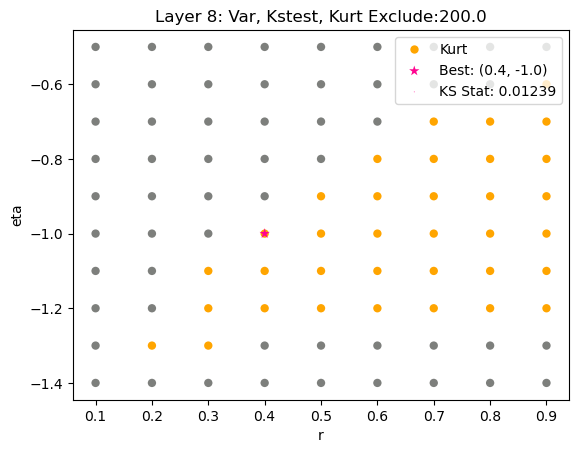

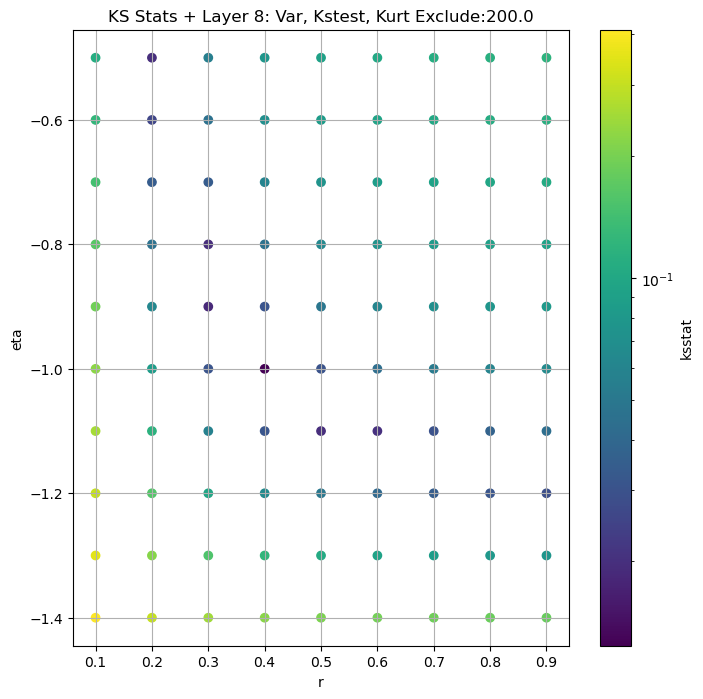

####
Layer  9


100%|██████████| 12760/12760 [00:44<00:00, 283.81it/s]


Finding Minimum after computing 12760 CDFs
9 0 0.025335676801698903 1.0218027


100%|██████████| 12760/12760 [00:45<00:00, 282.03it/s]


Finding Minimum after computing 12760 CDFs
9 25 0.02533396334552862 0.9051776


100%|██████████| 12760/12760 [00:44<00:00, 284.11it/s]


Finding Minimum after computing 12760 CDFs
9 50 0.02533382311430976 0.8645444


100%|██████████| 12760/12760 [00:44<00:00, 283.66it/s]


Finding Minimum after computing 12760 CDFs
9 75 0.02533521466775379 0.8339752


100%|██████████| 12760/12760 [00:44<00:00, 284.31it/s]


Finding Minimum after computing 12760 CDFs
9 100 0.02533514069032705 0.80877584


100%|██████████| 12760/12760 [00:45<00:00, 282.87it/s]


Finding Minimum after computing 12760 CDFs
9 150 0.025334525103851036 0.7678166


100%|██████████| 12760/12760 [00:45<00:00, 281.82it/s]


Finding Minimum after computing 12760 CDFs
9 200 0.025334402834612968 0.7346373


100%|██████████| 12760/12760 [00:44<00:00, 285.45it/s]


Finding Minimum after computing 12760 CDFs
9 250 0.025334292191186658 0.7064321


100%|██████████| 12760/12760 [00:44<00:00, 285.73it/s]


Finding Minimum after computing 12760 CDFs
9 300 0.025334189774259386 0.681747


100%|██████████| 12760/12760 [00:44<00:00, 283.98it/s]


Finding Minimum after computing 12760 CDFs
9 350 0.02532958641169336 0.6597257


100%|██████████| 12760/12760 [00:45<00:00, 280.06it/s]


Finding Minimum after computing 12760 CDFs
9 500 0.02532975558148587 0.60480857
Number of samples: 100000, Without approximation : 272080000.0


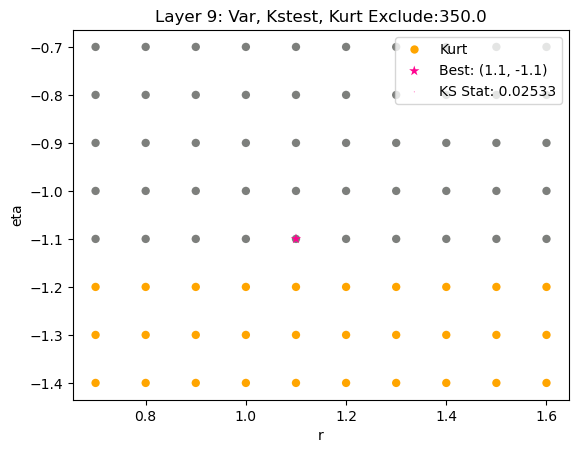

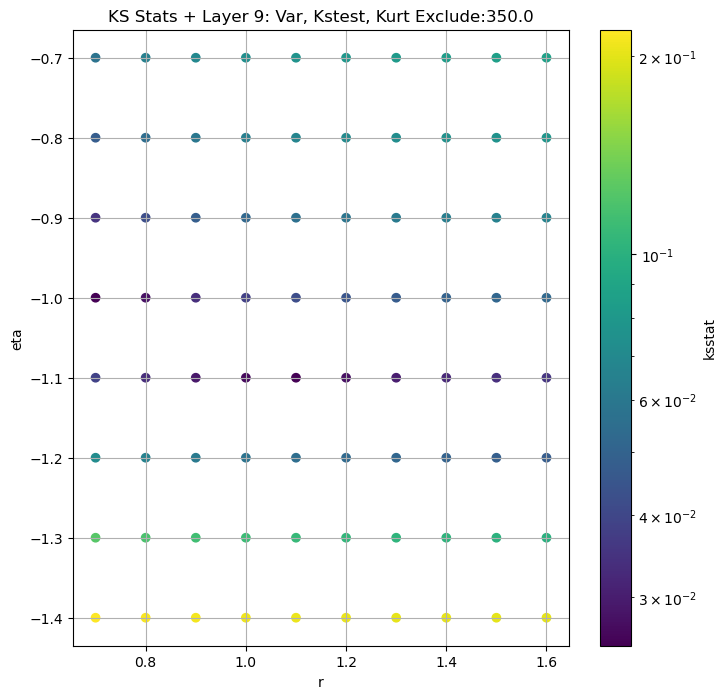

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                     
2      20586.120000  19258.777000  21997.203000    4.579008    3.067372   
3       5586.042500   5083.030300   6169.862300   12.162527    6.823176   
4       1803.625200   1653.475500   1972.172700    9.509400    6.386293   
5        518.531700    474.718600    568.606450   10.222363    6.526305   
6        123.448410    112.812614    135.501390   10.630472    6.988778   
7         26.474886     23.729076     30.007523   18.564669    9.779378   
8          5.566022      4.824710      6.910763   45.434100   13.918406   
9          1.021803      0.856540      1.428081  105.147964   15.814442   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        6.877853        27208.0             0.014079        6.9         -1.0   
3       25.538519       108832.0             0.133080        0.6         -1.3   
4       18.198275       333298.0             0.077800        0.6         -1.3   
5       26.454138      1149538.0             0.043060        4.1         -1.3   
6       22.231544      4251250.0             0.013504        1.2         -1.2   
7       60.509160     17005000.0             0.012624        1.3         -1.2   
8      216.776810     68020000.0             0.012392        0.4         -1.0   
9      464.557600    272080000.0             0.025330        1.1         -1.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       65090.978199                     0.0        20586.120000   
3       14964.664457                     0.0         5586.042500   
4        4831.801169                     0.0         1803.625200   
5        2544.257130                   500.0          391.182000   
6         429.118637                    75.0          113.420430   
7          78.086046                   350.0           19.789452   
8           0.866623                   200.0            4.228874   
9           1.789810                   350.0            0.659726   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.008227  
3                     0.004115  
4                     0.002352  
5                     0.001267  
6                     0.000659  
7                     0.000329  
8                     0.000165  
9                     0.000082

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/167 [00:00<?, ?it/s]

100%|██████████| 167/167 [00:00<00:00, 833.93it/s]


Finding Minimum after computing 167 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.013941257578019894, var: 17581.818359375


100%|██████████| 167/167 [00:00<00:00, 1093.53it/s]


Finding Minimum after computing 167 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.014126009499108583, var: 18071.634765625


100%|██████████| 167/167 [00:00<00:00, 1098.24it/s]


Finding Minimum after computing 167 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.014054541007426313, var: 18633.05859375


100%|██████████| 167/167 [00:00<00:00, 1114.64it/s]


Finding Minimum after computing 167 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.01421354692130622, var: 19327.27734375


100%|██████████| 167/167 [00:00<00:00, 1095.94it/s]


Finding Minimum after computing 167 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.014079478815237523, var: 20586.119140625
Number of samples: 27208, Without approximation : 27208.0


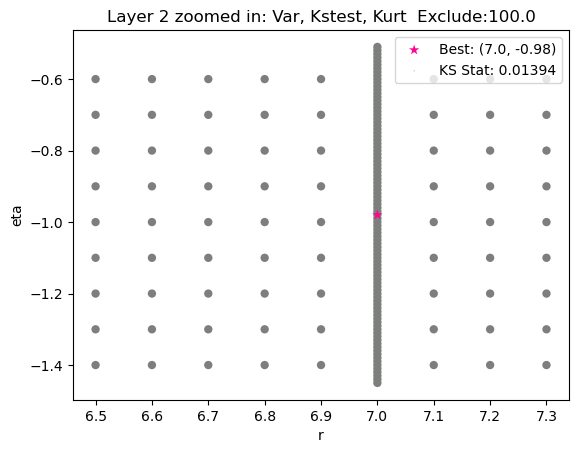

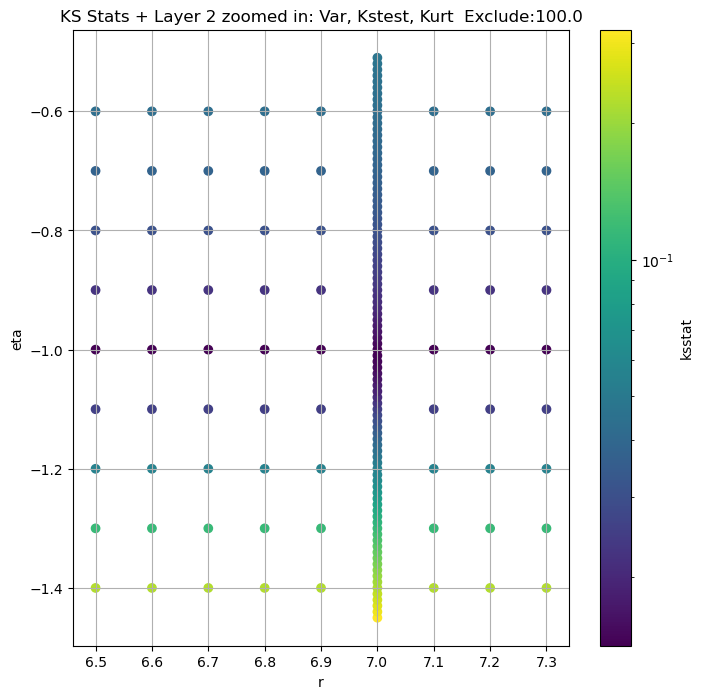

Layer 3


100%|██████████| 1125/1125 [00:04<00:00, 259.97it/s]


Finding Minimum after computing 1125 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.13307999999999975, var: 5001.92724609375


100%|██████████| 1125/1125 [00:03<00:00, 292.39it/s]


Finding Minimum after computing 1125 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.13307999999999975, var: 5091.31494140625


100%|██████████| 1125/1125 [00:03<00:00, 290.01it/s]


Finding Minimum after computing 1125 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.13307999999999975, var: 5194.31201171875


100%|██████████| 1125/1125 [00:03<00:00, 292.68it/s]


Finding Minimum after computing 1125 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.13307999999999975, var: 5321.48779296875


100%|██████████| 1125/1125 [00:03<00:00, 292.36it/s]


Finding Minimum after computing 1125 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.13307999999999975, var: 5586.04248046875
Number of samples: 100000, Without approximation : 108832.0


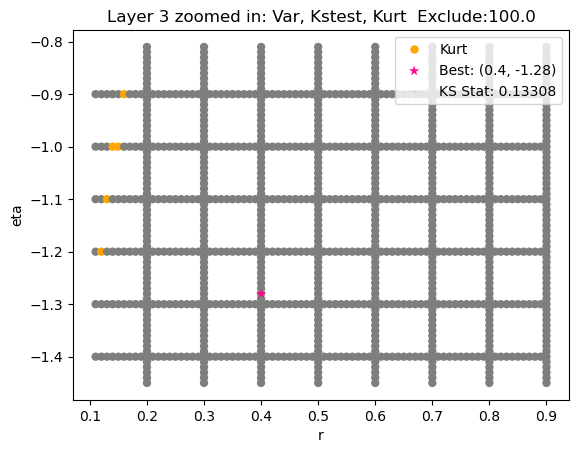

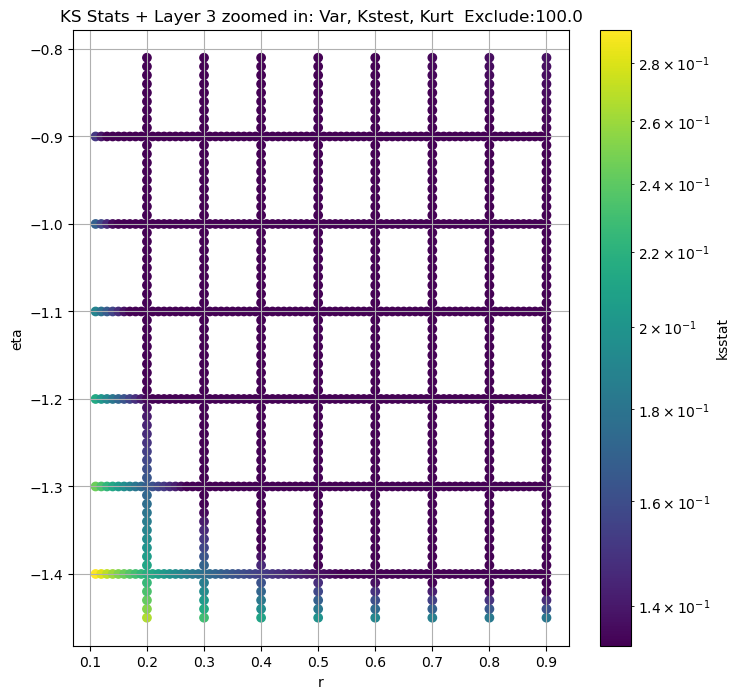

Layer 4


100%|██████████| 1125/1125 [00:03<00:00, 285.98it/s]


Finding Minimum after computing 1125 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.07779999999999981, var: 1636.6982421875


100%|██████████| 1125/1125 [00:03<00:00, 289.03it/s]


Finding Minimum after computing 1125 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.07779999999999981, var: 1664.5211181640625


100%|██████████| 1125/1125 [00:03<00:00, 290.63it/s]


Finding Minimum after computing 1125 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.07779999999999981, var: 1696.4163818359375


100%|██████████| 1125/1125 [00:03<00:00, 289.73it/s]


Finding Minimum after computing 1125 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.07779999999999981, var: 1735.333251953125


100%|██████████| 1125/1125 [00:04<00:00, 256.74it/s]


Finding Minimum after computing 1125 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.07779999999999981, var: 1803.625244140625
Number of samples: 100000, Without approximation : 333298.0


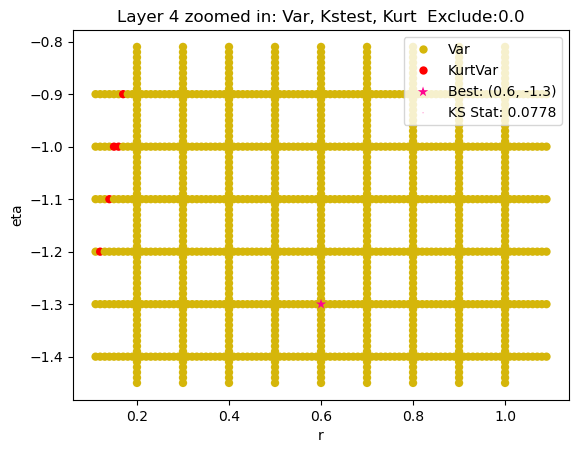

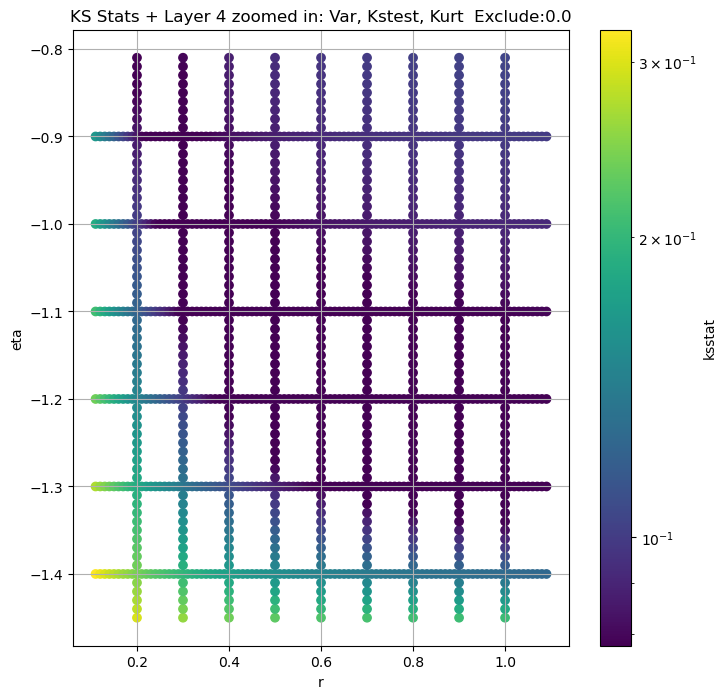

Layer 5


100%|██████████| 119/119 [00:00<00:00, 271.79it/s]


Finding Minimum after computing 119 CDFs
layer 5, 500.0 + 100 = 600, ksstat: 0.04309244388848693, var: 377.61151123046875


100%|██████████| 119/119 [00:00<00:00, 291.26it/s]


Finding Minimum after computing 119 CDFs
layer 5, 500.0 + 75 = 575, ksstat: 0.04309256227279257, var: 380.8770751953125


100%|██████████| 119/119 [00:00<00:00, 287.32it/s]


Finding Minimum after computing 119 CDFs
layer 5, 500.0 + 50 = 550, ksstat: 0.04309268212711498, var: 384.2265319824219


100%|██████████| 119/119 [00:00<00:00, 292.18it/s]


Finding Minimum after computing 119 CDFs
layer 5, 500.0 + 25 = 525, ksstat: 0.04305979370924973, var: 387.6594543457031


100%|██████████| 119/119 [00:00<00:00, 283.48it/s]


Finding Minimum after computing 119 CDFs
layer 5, 500.0 + 0 = 500, ksstat: 0.04305986856967786, var: 391.1820068359375


100%|██████████| 119/119 [00:00<00:00, 290.28it/s]


Finding Minimum after computing 119 CDFs
layer 5, 500.0 + -25 = 475, ksstat: 0.043059907189475555, var: 394.8099060058594


100%|██████████| 119/119 [00:00<00:00, 291.20it/s]


Finding Minimum after computing 119 CDFs
layer 5, 500.0 + -50 = 450, ksstat: 0.04306005061138912, var: 398.5429992675781


100%|██████████| 119/119 [00:00<00:00, 295.09it/s]


Finding Minimum after computing 119 CDFs
layer 5, 500.0 + -75 = 425, ksstat: 0.04306024213807169, var: 402.3921203613281


100%|██████████| 119/119 [00:00<00:00, 294.33it/s]


Finding Minimum after computing 119 CDFs
layer 5, 500.0 + -100 = 400, ksstat: 0.04306043680554589, var: 406.3617858886719
Number of samples: 100000, Without approximation : 1149538.0


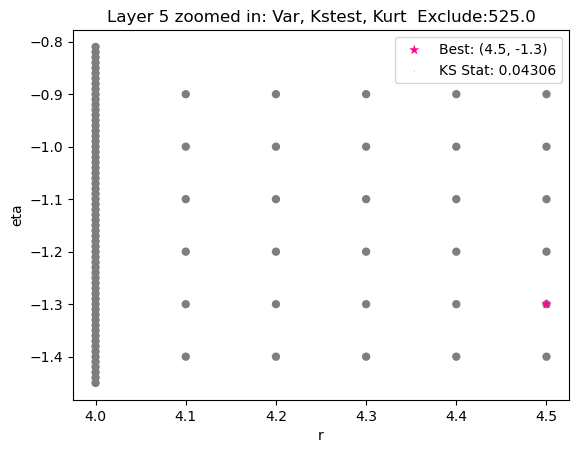

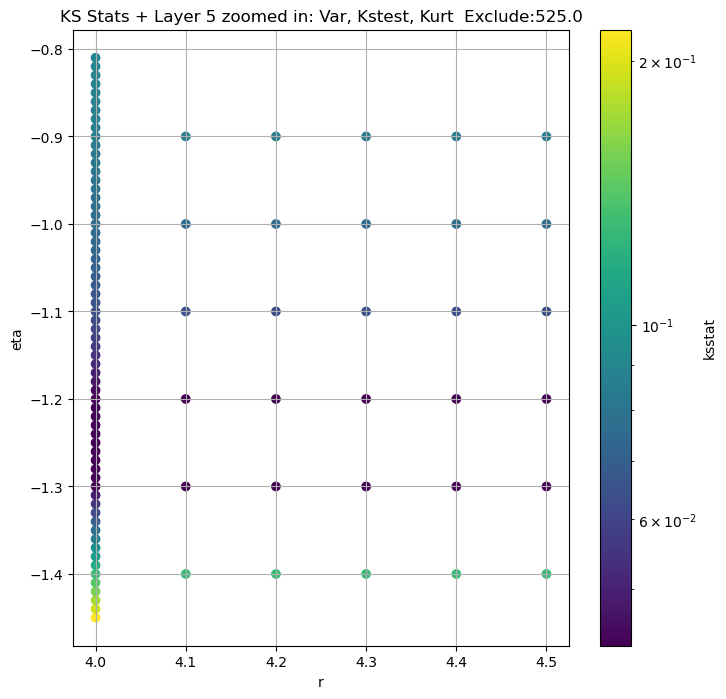

Layer 6


100%|██████████| 1305/1305 [00:04<00:00, 261.72it/s]


Finding Minimum after computing 1305 CDFs
layer 6, 75.0 + 100 = 175, ksstat: 0.013034824032254144, var: 106.408447265625


100%|██████████| 1305/1305 [00:04<00:00, 294.78it/s]


Finding Minimum after computing 1305 CDFs
layer 6, 75.0 + 75 = 150, ksstat: 0.012298067373353816, var: 107.93656921386719


100%|██████████| 1305/1305 [00:04<00:00, 298.27it/s]


Finding Minimum after computing 1305 CDFs
layer 6, 75.0 + 50 = 125, ksstat: 0.012324137053019713, var: 109.59086608886719


100%|██████████| 1305/1305 [00:04<00:00, 300.42it/s]


Finding Minimum after computing 1305 CDFs
layer 6, 75.0 + 25 = 100, ksstat: 0.012072615774992135, var: 111.40095520019531


100%|██████████| 1305/1305 [00:04<00:00, 299.17it/s]


Finding Minimum after computing 1305 CDFs
layer 6, 75.0 + 0 = 75, ksstat: 0.012381580671230186, var: 113.4204330444336


100%|██████████| 1305/1305 [00:04<00:00, 299.43it/s]


Finding Minimum after computing 1305 CDFs
layer 6, 75.0 + -25 = 50, ksstat: 0.012054754877155904, var: 115.73596954345703


100%|██████████| 1305/1305 [00:04<00:00, 298.22it/s]


Finding Minimum after computing 1305 CDFs
layer 6, 75.0 + -50 = 25, ksstat: 0.011546460676330972, var: 118.56324005126953


100%|██████████| 1305/1305 [00:04<00:00, 299.95it/s]


Finding Minimum after computing 1305 CDFs
layer 6, 75.0 + -75 = 0, ksstat: 0.010978678032022404, var: 123.44841003417969
Number of samples: 100000, Without approximation : 4251250.0


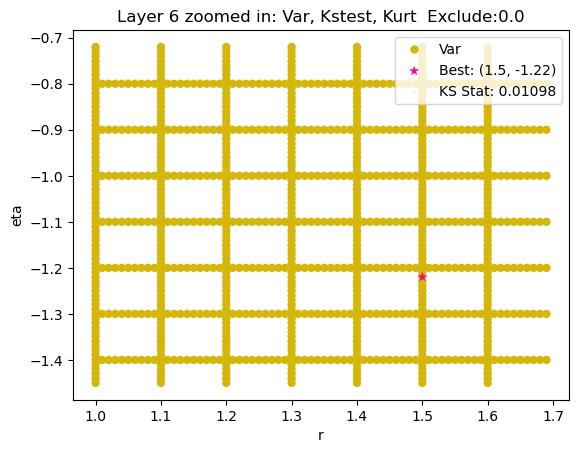

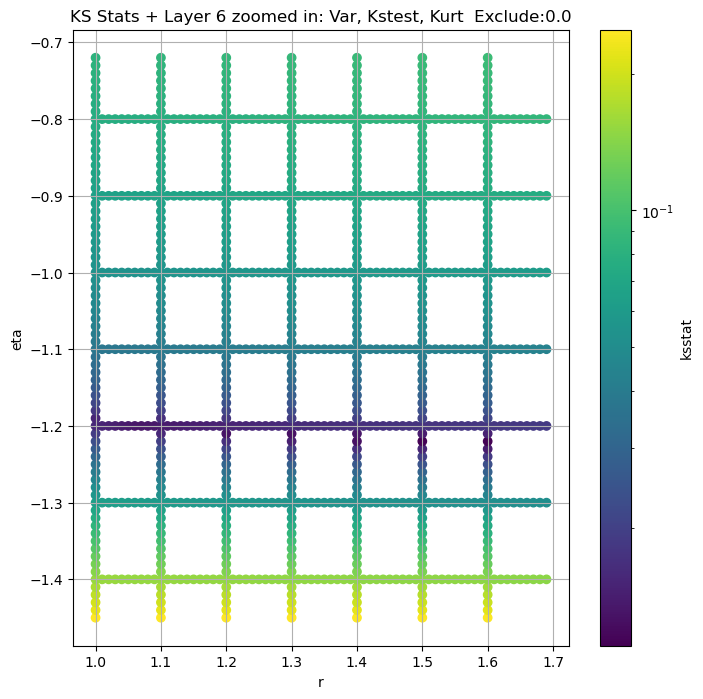

Layer 7


100%|██████████| 1305/1305 [00:04<00:00, 291.54it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + 100 = 450, ksstat: 0.011892964744337542, var: 18.848947525024414


100%|██████████| 1305/1305 [00:04<00:00, 293.91it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + 75 = 425, ksstat: 0.012064476373163546, var: 19.071340560913086


100%|██████████| 1305/1305 [00:04<00:00, 293.19it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + 50 = 400, ksstat: 0.012292808467205457, var: 19.301799774169922


100%|██████████| 1305/1305 [00:04<00:00, 285.27it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + 25 = 375, ksstat: 0.011547966664637976, var: 19.54094886779785


100%|██████████| 1305/1305 [00:04<00:00, 296.51it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + 0 = 350, ksstat: 0.011614351517805654, var: 19.789451599121094


100%|██████████| 1305/1305 [00:04<00:00, 292.31it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + -25 = 325, ksstat: 0.011973211255224214, var: 20.04833984375


100%|██████████| 1305/1305 [00:04<00:00, 299.20it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + -50 = 300, ksstat: 0.011984572903874668, var: 20.318769454956055


100%|██████████| 1305/1305 [00:04<00:00, 296.83it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + -75 = 275, ksstat: 0.011995890210672933, var: 20.60197639465332


100%|██████████| 1305/1305 [00:04<00:00, 294.97it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + -100 = 250, ksstat: 0.012397882129890125, var: 20.899560928344727
Number of samples: 100000, Without approximation : 17005000.0


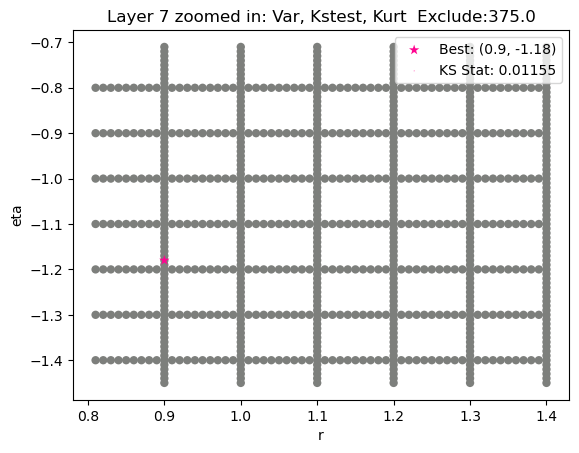

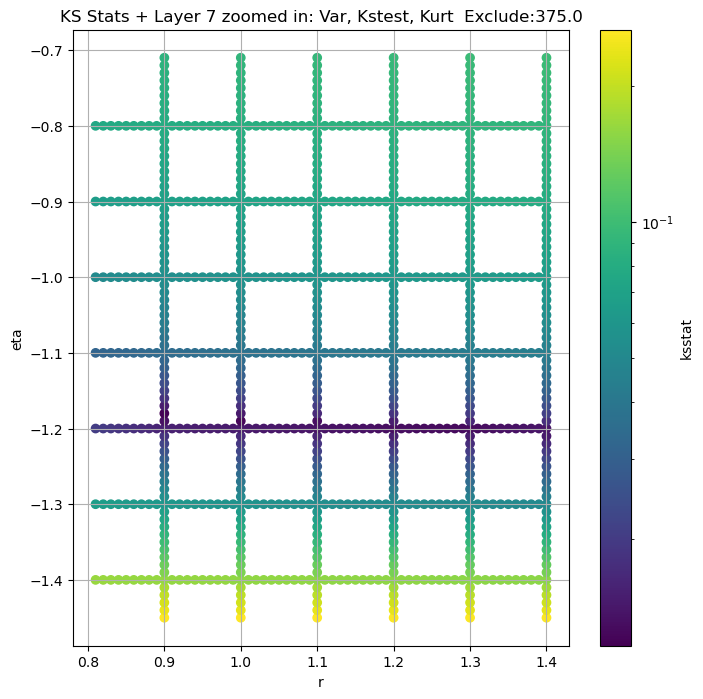

Layer 8


100%|██████████| 1480/1480 [00:05<00:00, 266.56it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 200.0 + 100 = 300, ksstat: 0.012391443653863021, var: 3.938030481338501


100%|██████████| 1480/1480 [00:05<00:00, 286.75it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 200.0 + 75 = 275, ksstat: 0.012391225212073254, var: 4.004324913024902


100%|██████████| 1480/1480 [00:05<00:00, 291.03it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 200.0 + 50 = 250, ksstat: 0.012391301109316522, var: 4.074504852294922


100%|██████████| 1480/1480 [00:05<00:00, 285.11it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 200.0 + 25 = 225, ksstat: 0.012392117290598303, var: 4.14911413192749


100%|██████████| 1480/1480 [00:05<00:00, 280.96it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 200.0 + 0 = 200, ksstat: 0.012392191981205003, var: 4.2288737297058105


100%|██████████| 1480/1480 [00:05<00:00, 279.39it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 200.0 + -25 = 175, ksstat: 0.012392270080444523, var: 4.31475830078125


100%|██████████| 1480/1480 [00:05<00:00, 267.41it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 200.0 + -50 = 150, ksstat: 0.012391006007406058, var: 4.408092975616455


100%|██████████| 1480/1480 [00:05<00:00, 285.19it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 200.0 + -75 = 125, ksstat: 0.012391108841767084, var: 4.510650157928467


100%|██████████| 1480/1480 [00:05<00:00, 286.60it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 200.0 + -100 = 100, ksstat: 0.012393381187249752, var: 4.625241279602051
Number of samples: 100000, Without approximation : 68020000.0


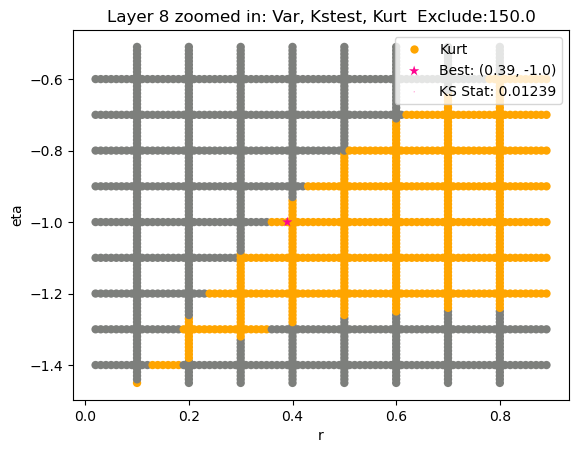

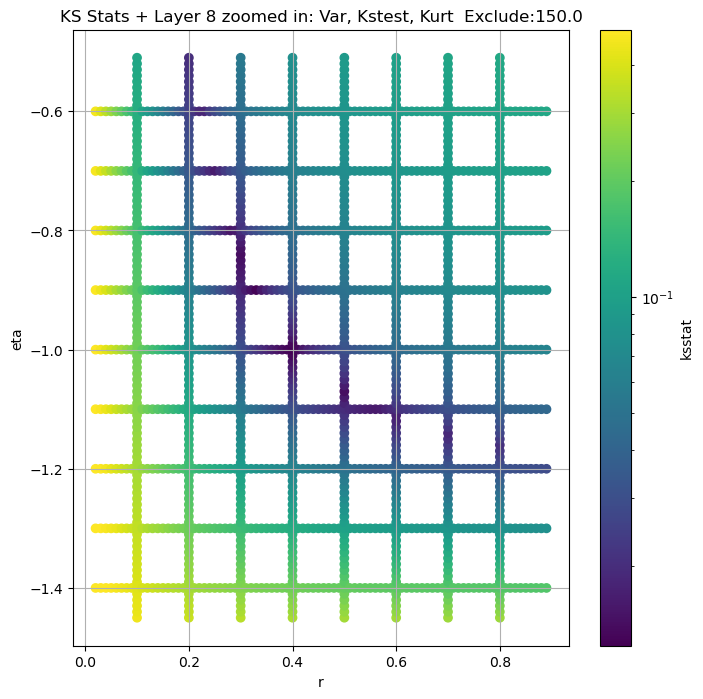

Layer 9


100%|██████████| 1485/1485 [00:05<00:00, 275.63it/s]


Finding Minimum after computing 1485 CDFs
layer 9, 350.0 + 100 = 450, ksstat: 0.025329524760448918, var: 0.6215964555740356


100%|██████████| 1485/1485 [00:05<00:00, 288.37it/s]


Finding Minimum after computing 1485 CDFs
layer 9, 350.0 + 75 = 425, ksstat: 0.025329496854945566, var: 0.6305117607116699


100%|██████████| 1485/1485 [00:05<00:00, 283.96it/s]


Finding Minimum after computing 1485 CDFs
layer 9, 350.0 + 50 = 400, ksstat: 0.02532950143626722, var: 0.639812171459198


100%|██████████| 1485/1485 [00:05<00:00, 284.58it/s]


Finding Minimum after computing 1485 CDFs
layer 9, 350.0 + 25 = 375, ksstat: 0.025329505029830113, var: 0.6495338678359985


100%|██████████| 1485/1485 [00:05<00:00, 286.88it/s]


Finding Minimum after computing 1485 CDFs
layer 9, 350.0 + 0 = 350, ksstat: 0.025329507700730503, var: 0.6597257256507874


100%|██████████| 1485/1485 [00:05<00:00, 282.38it/s]


Finding Minimum after computing 1485 CDFs
layer 9, 350.0 + -25 = 325, ksstat: 0.02532946662081792, var: 0.670443058013916


100%|██████████| 1485/1485 [00:05<00:00, 285.33it/s]


Finding Minimum after computing 1485 CDFs
layer 9, 350.0 + -50 = 300, ksstat: 0.025329465594761902, var: 0.6817470192909241


100%|██████████| 1485/1485 [00:05<00:00, 286.65it/s]


Finding Minimum after computing 1485 CDFs
layer 9, 350.0 + -75 = 275, ksstat: 0.02532946377734202, var: 0.6937121152877808


100%|██████████| 1485/1485 [00:05<00:00, 286.85it/s]


Finding Minimum after computing 1485 CDFs
layer 9, 350.0 + -100 = 250, ksstat: 0.0253294613614653, var: 0.7064321041107178
Number of samples: 100000, Without approximation : 272080000.0


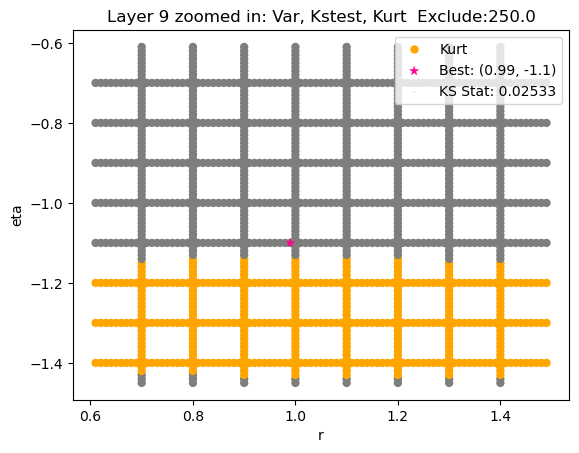

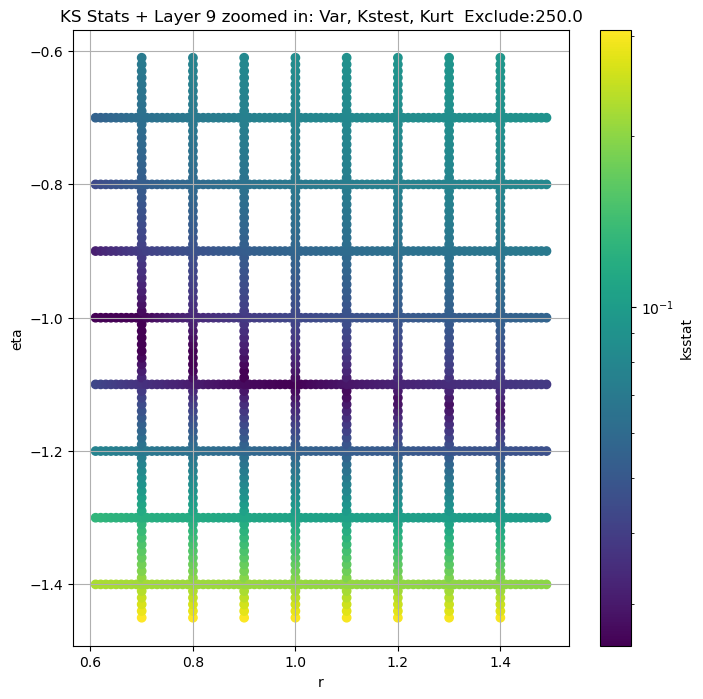

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                     
2      20586.120000  19258.777000  21997.203000    4.579008    3.067372   
3       5586.042500   5083.030300   6169.862300   12.162527    6.823176   
4       1803.625200   1653.475500   1972.172700    9.509400    6.386293   
5        518.531700    474.718600    568.606450   10.222363    6.526305   
6        123.448410    112.812614    135.501390   10.630472    6.988778   
7         26.474886     23.729076     30.007523   18.564669    9.779378   
8          5.566022      4.824710      6.910763   45.434100   13.918406   
9          1.021803      0.856540      1.428081  105.147964   15.814442   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        6.877853        27208.0             0.014079        6.9         -1.0   
3       25.538519       108832.0             0.133080        0.6         -1.3   
4       18.198275       333298.0             0.077800        0.6         -1.3   
5       26.454138      1149538.0             0.043060        4.1         -1.3   
6       22.231544      4251250.0             0.013504        1.2         -1.2   
7       60.509160     17005000.0             0.012624        1.3         -1.2   
8      216.776810     68020000.0             0.012392        0.4         -1.0   
9      464.557600    272080000.0             0.025330        1.1         -1.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       65090.978199                     0.0        17581.818359   
3       14964.664457                     0.0         5001.927246   
4        4831.801169                     0.0         1803.625200   
5        2544.257130                   500.0          387.659454   
6         429.118637                    75.0          123.448410   
7          78.086046                   350.0           19.540949   
8           0.866623                   200.0            4.408093   
9           1.789810                   350.0            0.706432   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.008227          0.013941    7.00     -0.98   
3                     0.004115          0.133080    0.40     -1.28   
4                     0.002352          0.077800    0.60     -1.30   
5                     0.001267          0.043060    4.50     -1.30   
6                     0.000659          0.010979    1.50     -1.22   
7                     0.000329          0.011548    0.90     -1.18   
8                     0.000165          0.012391    0.39     -1.00   
9                     0.000082          0.025329    0.99     -1.10   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      54117.062495                100.0         9682  
3       3857.723562                100.0          106  
4       4831.801169                  0.0          306  
5       2514.226846                525.0          945  
6        549.545353                  0.0        15760  
7         55.268481                375.0        14010  
8          0.799770                150.0        12454  
9          1.749340                250.0         2952

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

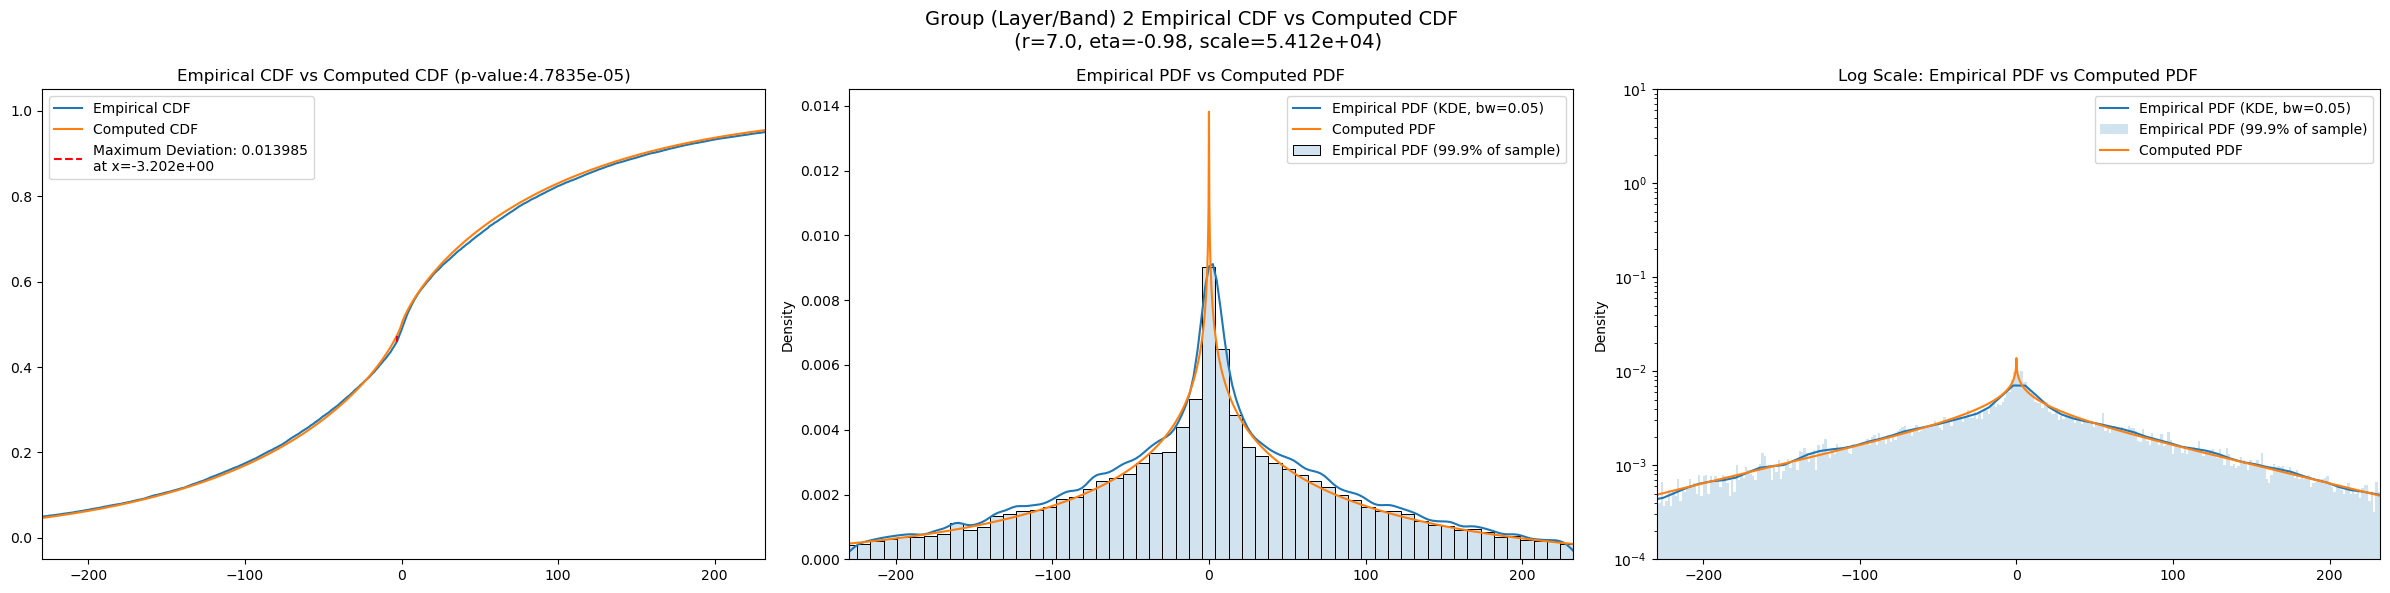

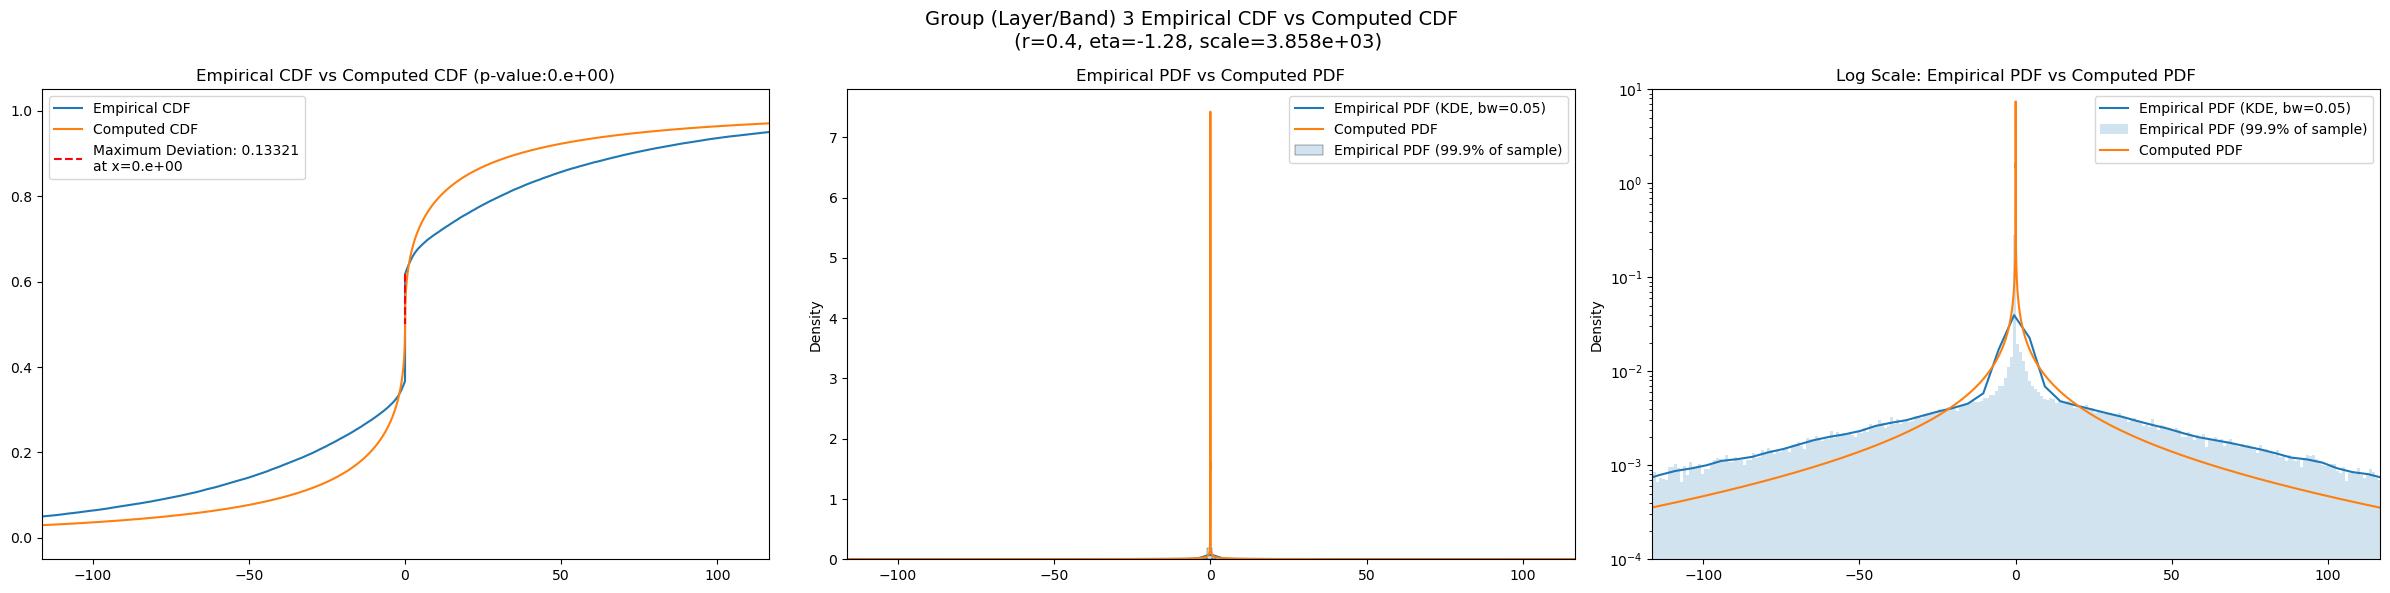

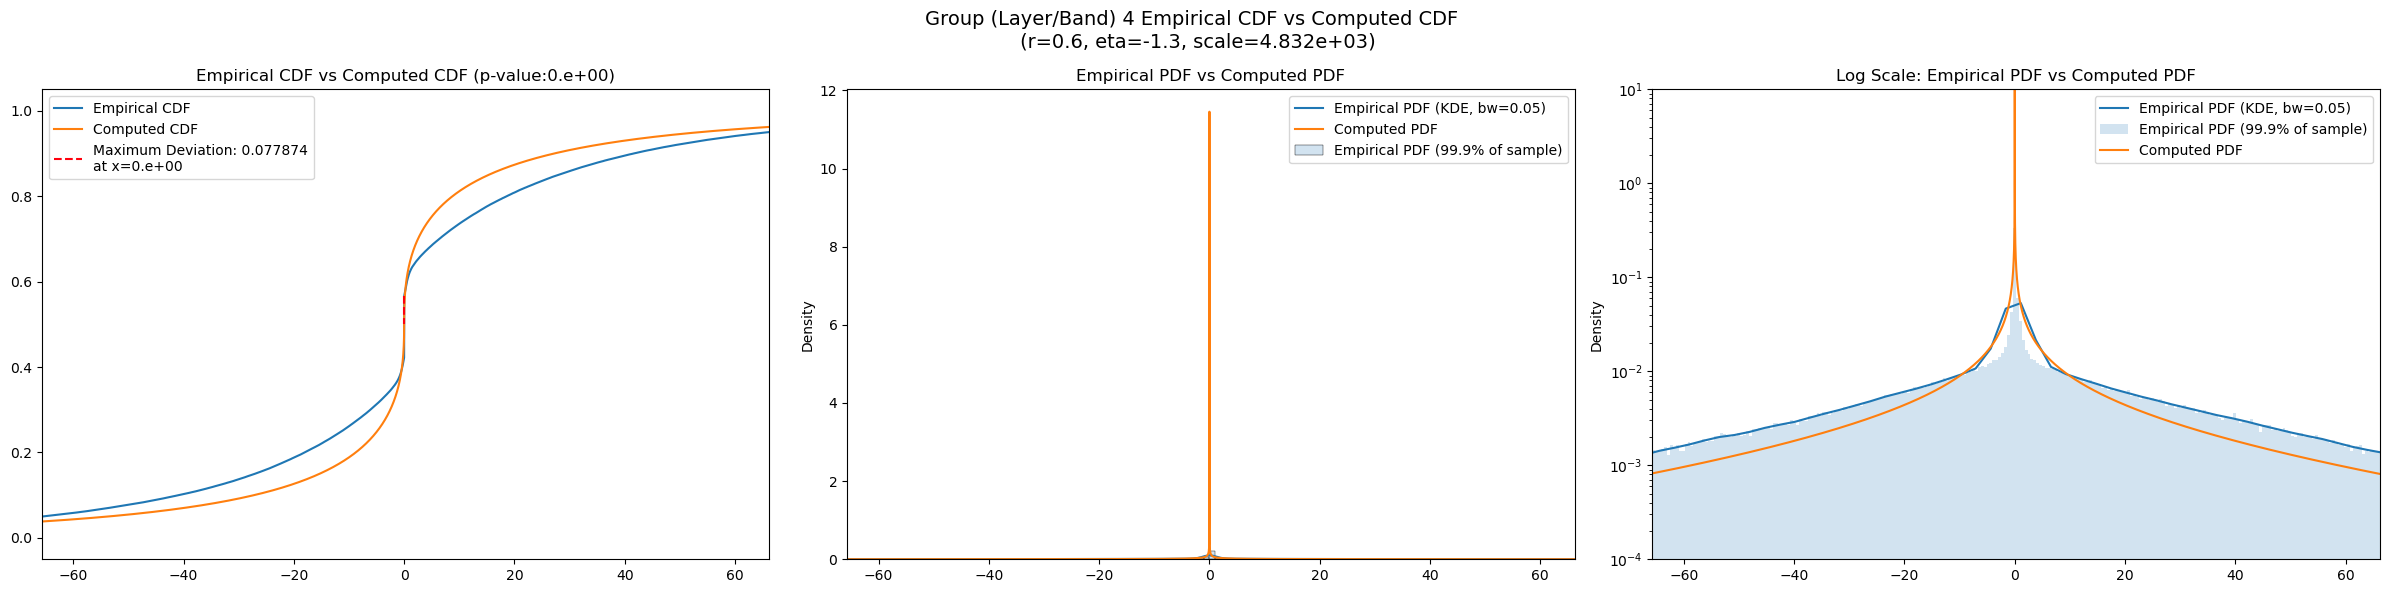

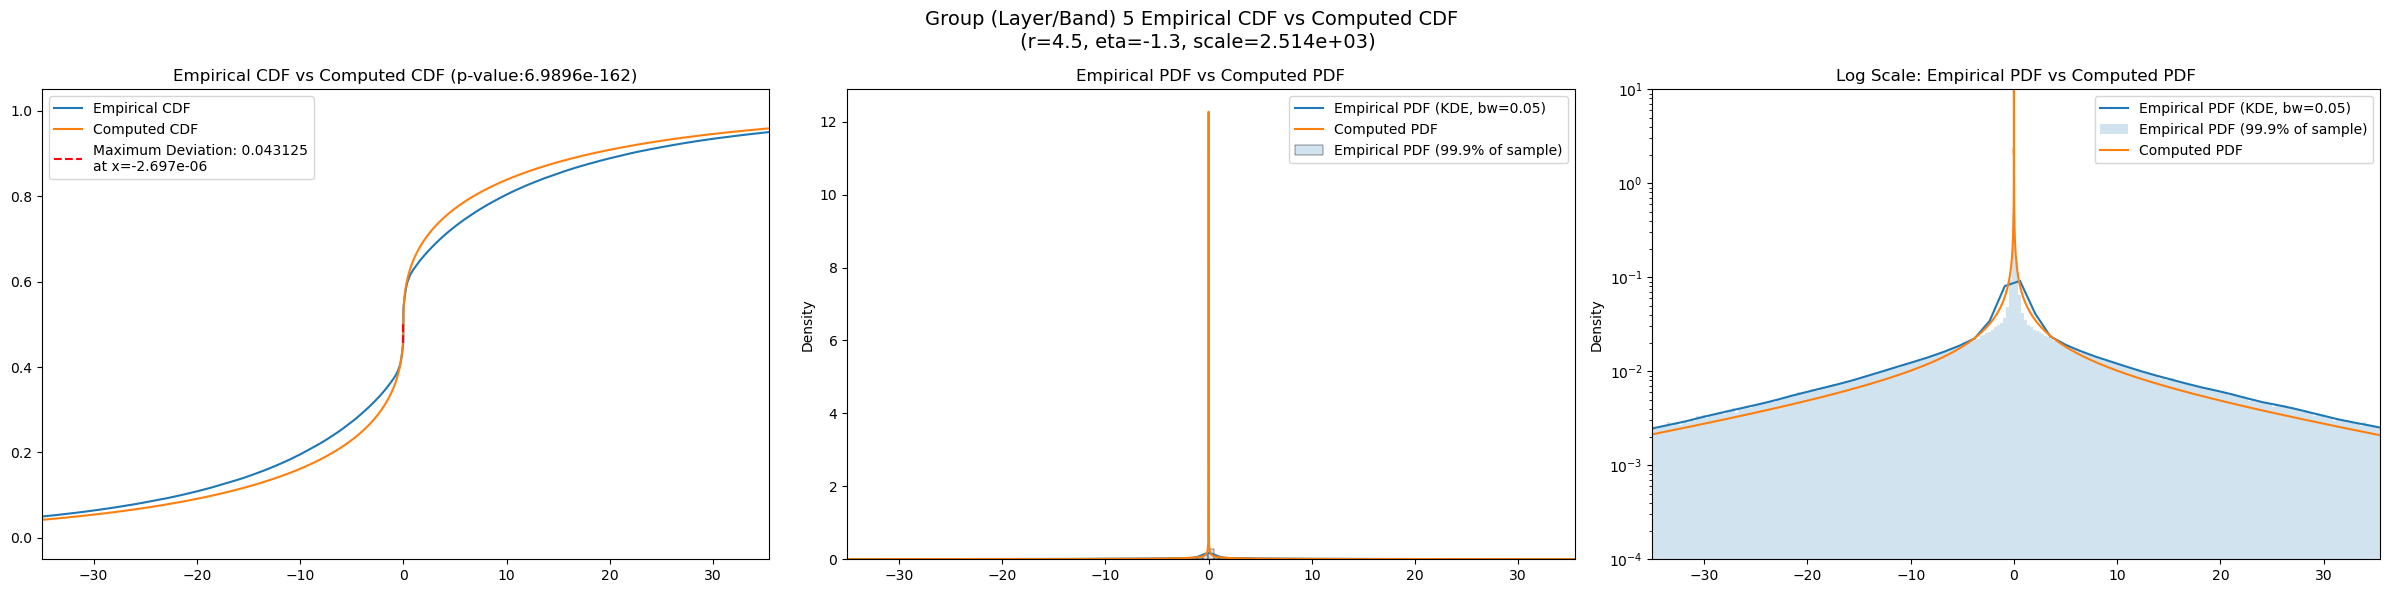

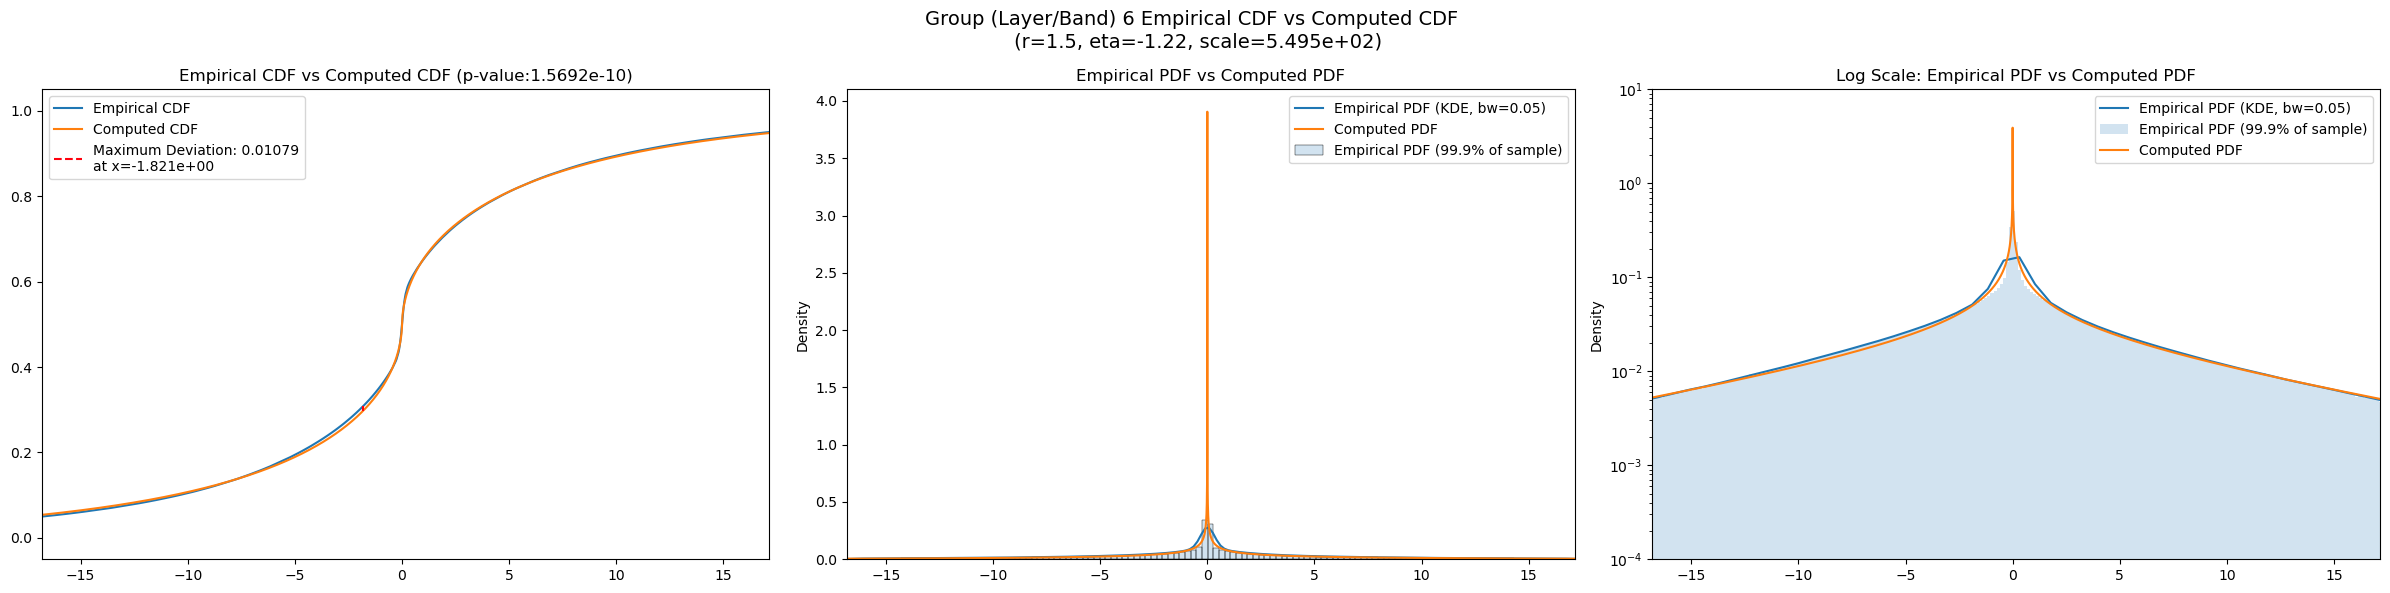

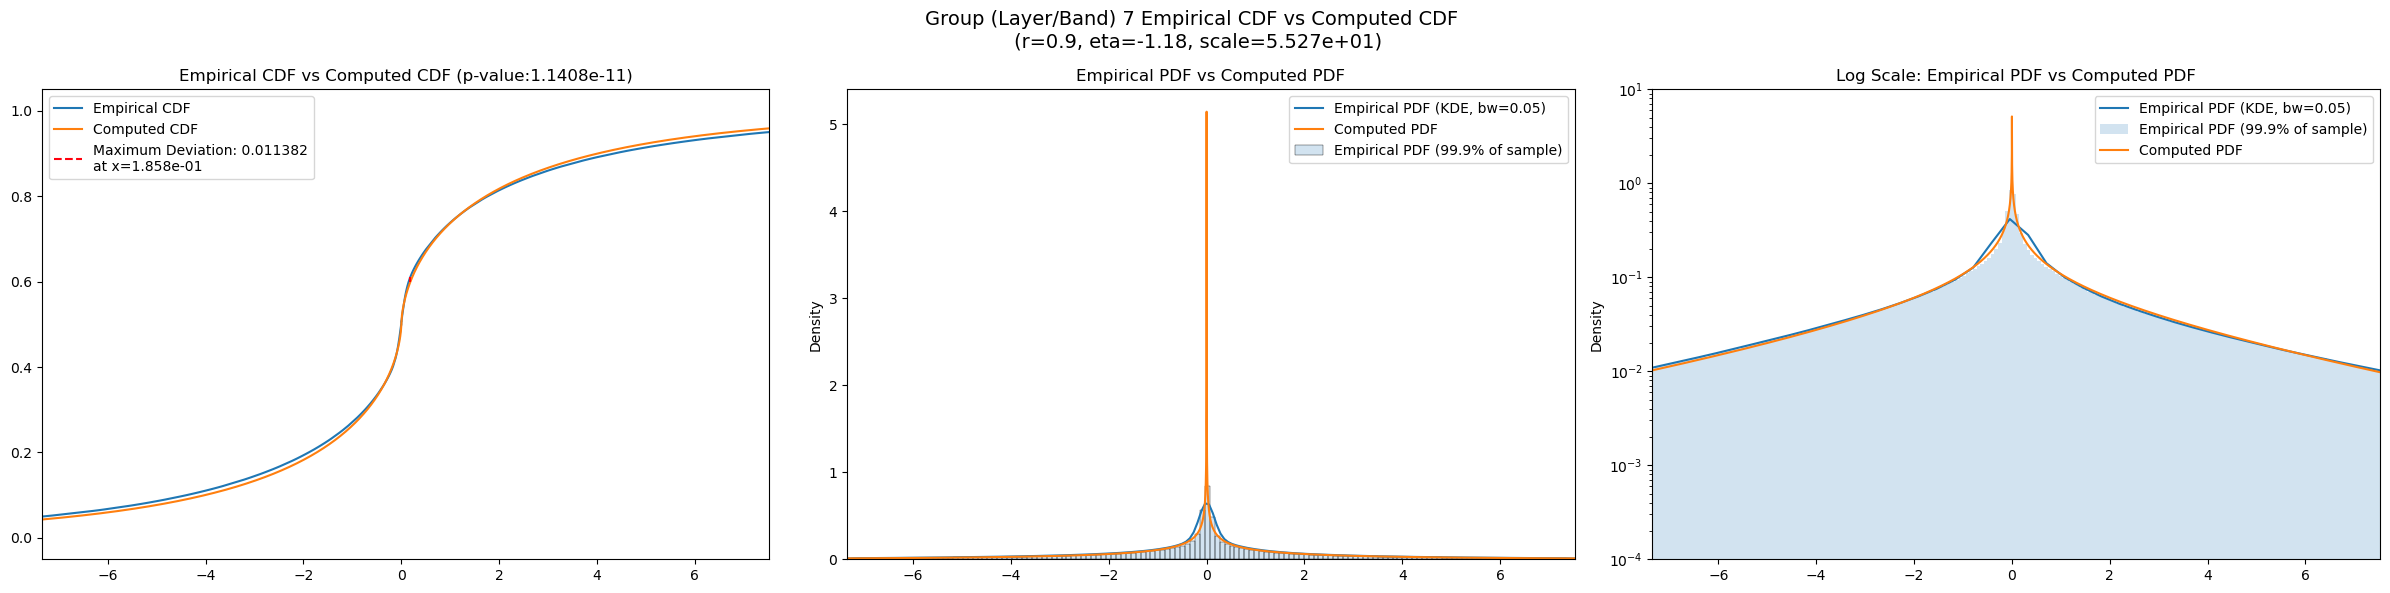

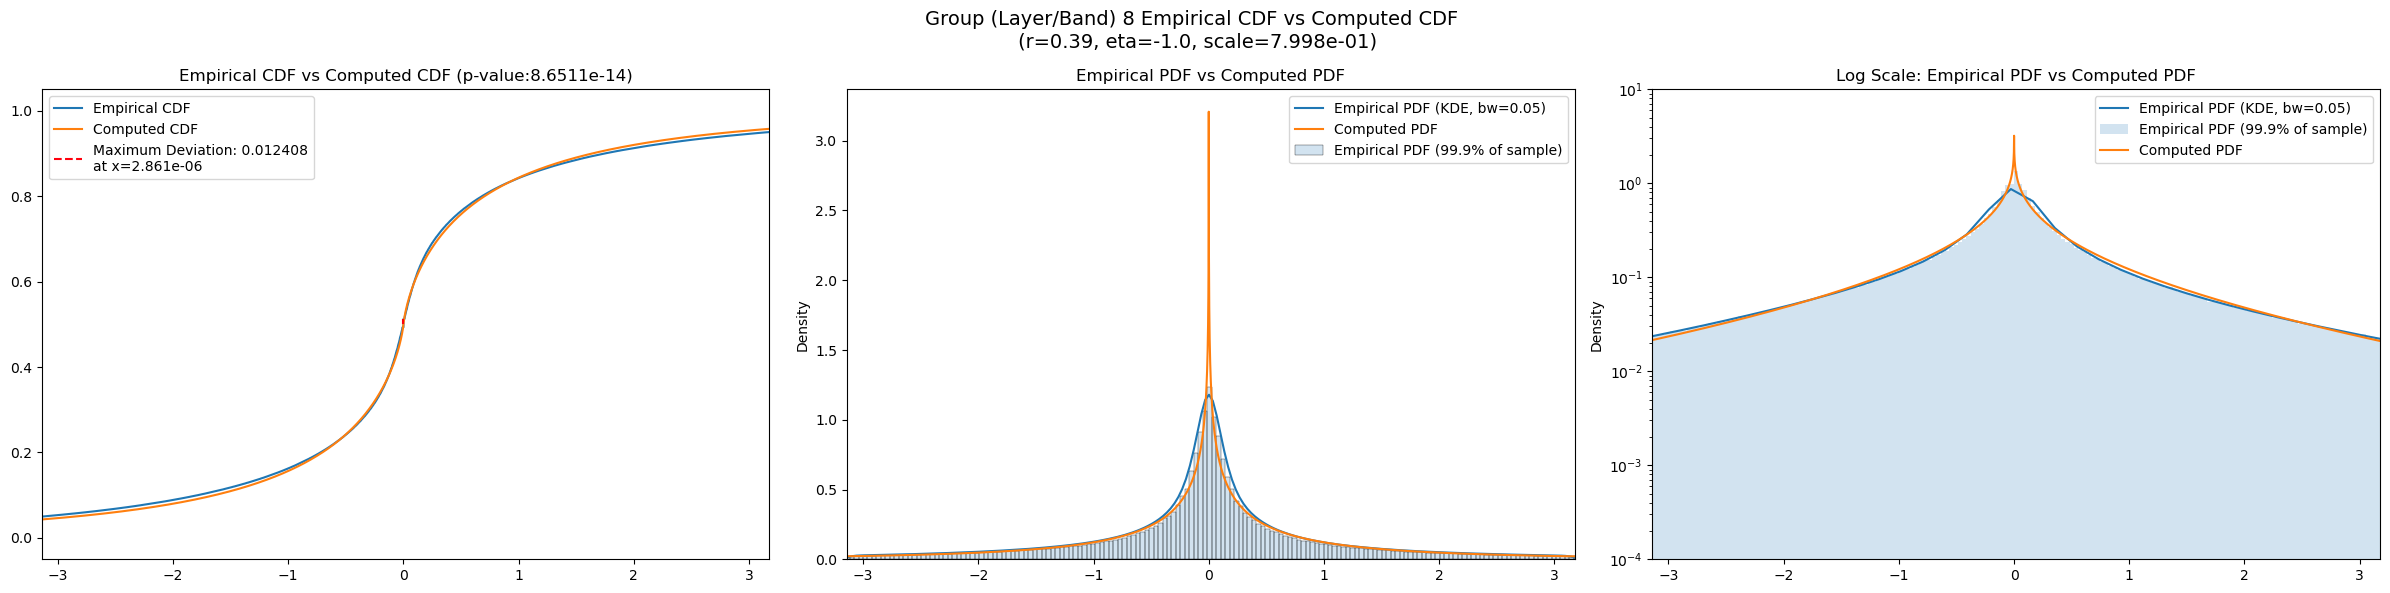

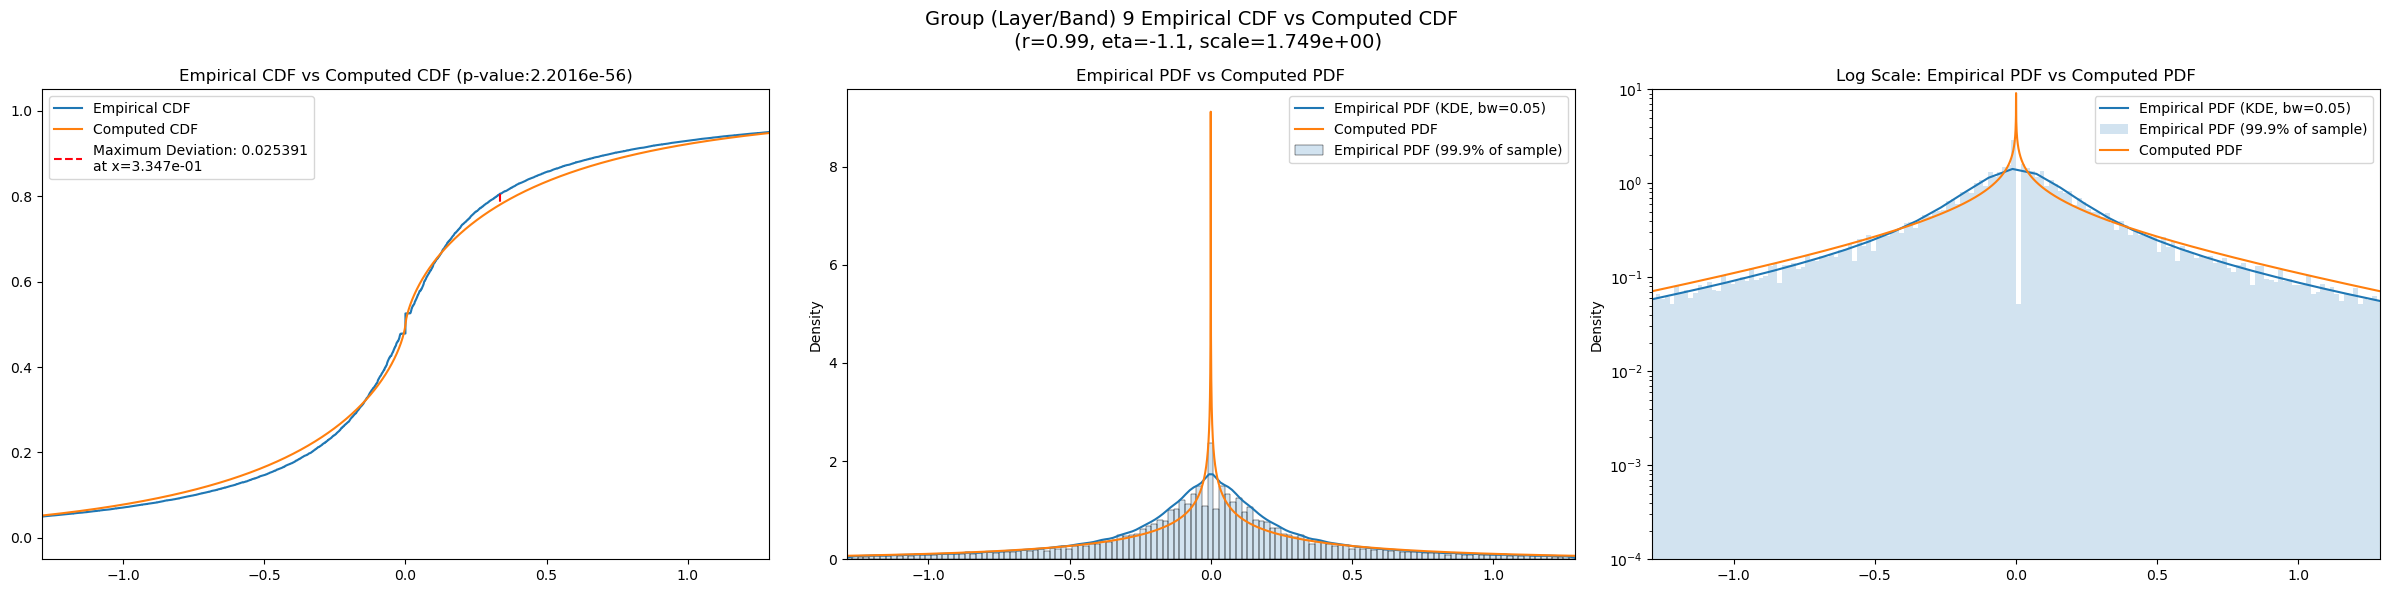

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                     
2      20586.120000  19258.777000  21997.203000    4.579008    3.067372   
3       5586.042500   5083.030300   6169.862300   12.162527    6.823176   
4       1803.625200   1653.475500   1972.172700    9.509400    6.386293   
5        518.531700    474.718600    568.606450   10.222363    6.526305   
6        123.448410    112.812614    135.501390   10.630472    6.988778   
7         26.474886     23.729076     30.007523   18.564669    9.779378   
8          5.566022      4.824710      6.910763   45.434100   13.918406   
9          1.021803      0.856540      1.428081  105.147964   15.814442   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        6.877853        27208.0             0.014079        6.9         -1.0   
3       25.538519       108832.0             0.133080        0.6         -1.3   
4       18.198275       333298.0             0.077800        0.6         -1.3   
5       26.454138      1149538.0             0.043060        4.1         -1.3   
6       22.231544      4251250.0             0.013504        1.2         -1.2   
7       60.509160     17005000.0             0.012624        1.3         -1.2   
8      216.776810     68020000.0             0.012392        0.4         -1.0   
9      464.557600    272080000.0             0.025330        1.1         -1.1   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...      102.032000              0.043843          6.952370e-46   
3      ...       22.542500              0.133839          0.000000e+00   
4      ...       16.978200              0.103783          0.000000e+00   
5      ...        9.975750              0.089730          0.000000e+00   
6      ...        5.256450              0.077096          0.000000e+00   
7      ...        2.104050              0.082592          0.000000e+00   
8      ...        0.881625              0.079140          0.000000e+00   
9      ...        0.445628              0.060203          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          84.795100             0.025508         8.221370e-16  71.377200   
3          15.517800             0.133090         0.000000e+00  12.501500   
4          13.106600             0.091381         0.000000e+00  10.581900   
5           7.723570             0.076333         0.000000e+00   6.212510   
6           4.226530             0.058957         0.000000e+00   3.410630   
7           1.739330             0.060916         0.000000e+00   1.379530   
8           0.763693             0.052915         0.000000e+00   0.599471   
9           0.392223             0.033041         0.000000e+00   0.312648   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.030389   2.902260e-22              0.000051  
3           0.133090   0.000000e+00              0.000000  
4           0.094232   0.000000e+00              0.000000  
5           0.079245   0.000000e+00              0.000000  
6           0.062675   0.000000e+00              0.000000  
7           0.064300   0.000000e+00              0.000000  
8           0.053934   0.000000e+00              0.000000  
9           0.031430   0.000000e+00              0.000000  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.014079                 0.008227          0.013941   
3                 0.133080                 0.004115          0.133080   
4                 0.077800                 0.002352          0.077800   
5                 0.043060                 0.001267          0.043060   
6                 0.013504                 0.000659          0.010979   
7                 0.012624                 0.000329          0.011548   
8                 0.012392                 0.000165          0.012391   
9                 0.025330                 0.000082          0.025329   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.043843             0.025508       0.030389  
3                  0.133839             0.133090       0.133090  
4                  0.103783             0.091381       0.094232  
5                  0.089730             0.076333       0.079245  
6                  0.077096             0.058957       0.062675  
7                  0.082592             0.060916       0.064300  
8                  0.079140             0.052915       0.053934  
9                  0.060203             0.033041       0.031430

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            17581.818359          0.013941    7.00     -0.98  54117.062495   
3             5001.927246          0.133080    0.40     -1.28   3857.723562   
4             1803.625200          0.077800    0.60     -1.30   4831.801169   
5              387.659454          0.043060    4.50     -1.30   2514.226846   
6              123.448410          0.010979    1.50     -1.22    549.545353   
7               19.540949          0.011548    0.90     -1.18     55.268481   
8                4.408093          0.012391    0.39     -1.00      0.799770   
9                0.706432          0.025329    0.99     -1.10      1.749340   

       best_exclude_cutoff  
layer                       
2                    100.0  
3                    100.0  
4                      0.0  
5                    525.0  
6                      0.0  
7                    375.0  
8                    150.0  
9                    250.0

In [21]:
eng.quit()